In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import keras_cnn
from algorithms.optimized_search import OptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pandas as pd
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


## Dependent Optimized Search quantization

In [2]:
input_shape = (32, 32, 3)
num_outputs = 10
num_kernels = 32
num_stages = 7
path_trained_weights = 'C:/Users/320060820/experiments/test_models/svhn_keras/svhn_seq_large_w_2.h5'
output_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/R Sequential L SVHN 2/'
name = 'svhn_seq_large'

from test_models.svhn_keras import data
_, test_data = data.get_data()

model_arch = keras_cnn.KerasCNNLarge(input_shape, num_outputs, num_kernels, num_stages, pool_layer_interval = 2, 
                                     path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
print(float_model_acc)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0.954479102642901


In [3]:
layer_names = [layer.name for layer in model_obj.model.layers if layer.name.startswith('conv2d') or \
               layer.name.startswith('dense')]
layer_names.reverse()
print(layer_names)

['dense_1', 'conv2d_14', 'conv2d_13', 'conv2d_12', 'conv2d_11', 'conv2d_10', 'conv2d_9', 'conv2d_8', 'conv2d_7', 'conv2d_6', 'conv2d_5', 'conv2d_4', 'conv2d_3', 'conv2d_2', 'conv2d_1']


### Function design for allocating accuracy drops per layer

In [4]:
total_acc_drop = 0.005
# Functions
# x: layer index
# n: total accuracy drop
# s: scale/number of layers
linear = lambda x, n, s: n/s * x
quadratic = lambda x, n, s: n/s**2 * x**2
cubic = lambda x, n, s: n/s**3 * x**3
exponential = lambda x, n, s: n/2**s * 2**x
log = lambda x, n, s: n/np.log(s) * np.log(x)
alloc_types = ['constant', 'linear', 'quadratic', 'cubic', 'exponential', 'log']

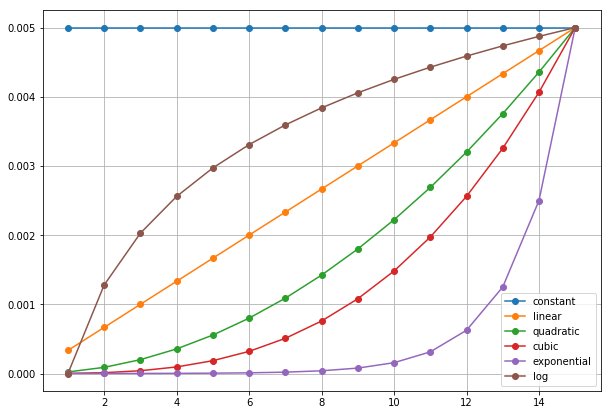

In [5]:
x = np.arange(1, len(layer_names) + 1, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = linear(x, n, num_layers)
y3 = quadratic(x, n, num_layers) # Quadratic
y4 = cubic(x, n, num_layers) # Cubic
y5 = exponential(x, n, num_layers) # Exponential
y6 = log(x, n, num_layers) # log

plt.figure(figsize=(10, 7))
plt.plot(x, y1, 'o-', label='constant');
plt.plot(x, y2, 'o-', label='linear');
plt.plot(x, y3, 'o-', label='quadratic');
plt.plot(x, y4, 'o-', label='cubic');
plt.plot(x, y5, 'o-', label='exponential');
plt.plot(x, y6, 'o-', label='log');
plt.grid();
plt.legend();

In [6]:
start_bw = 12
w_scores = {}
opt_params_weights = {}
acc_drop_w = {}

#### Constant

In [7]:
alloc_type = 'constant'

acc_drop_config = {
    layer: total_acc_drop for layer in layer_names
}
opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 13], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 13], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(2, 1) (3, 2) 0.0010464039924336593
Chosen:  (2, 1)
After quantizing layer dense_1 | Measured accuracy drop 0.0023745321366764613 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_14
(2, 4) (3, 4) 0.000563448303618169
Chosen:  (2, 4)
After quantizing layer conv2d_14 | Measured accuracy drop 0.0028172415180907286 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_13
(3, 4) (4, 5) 0.0008854187628285349
Chosen:  (3, 4)
After quantizing layer conv2d_13 | Measured accuracy drop 0.004225862277136093 | Acceptable accuracy drop: 0.005
Quantizing

Floating point model accuracy: 95.448 %
Quantized model accuracy: 94.998 %
Accuracy drop of 0.471 %


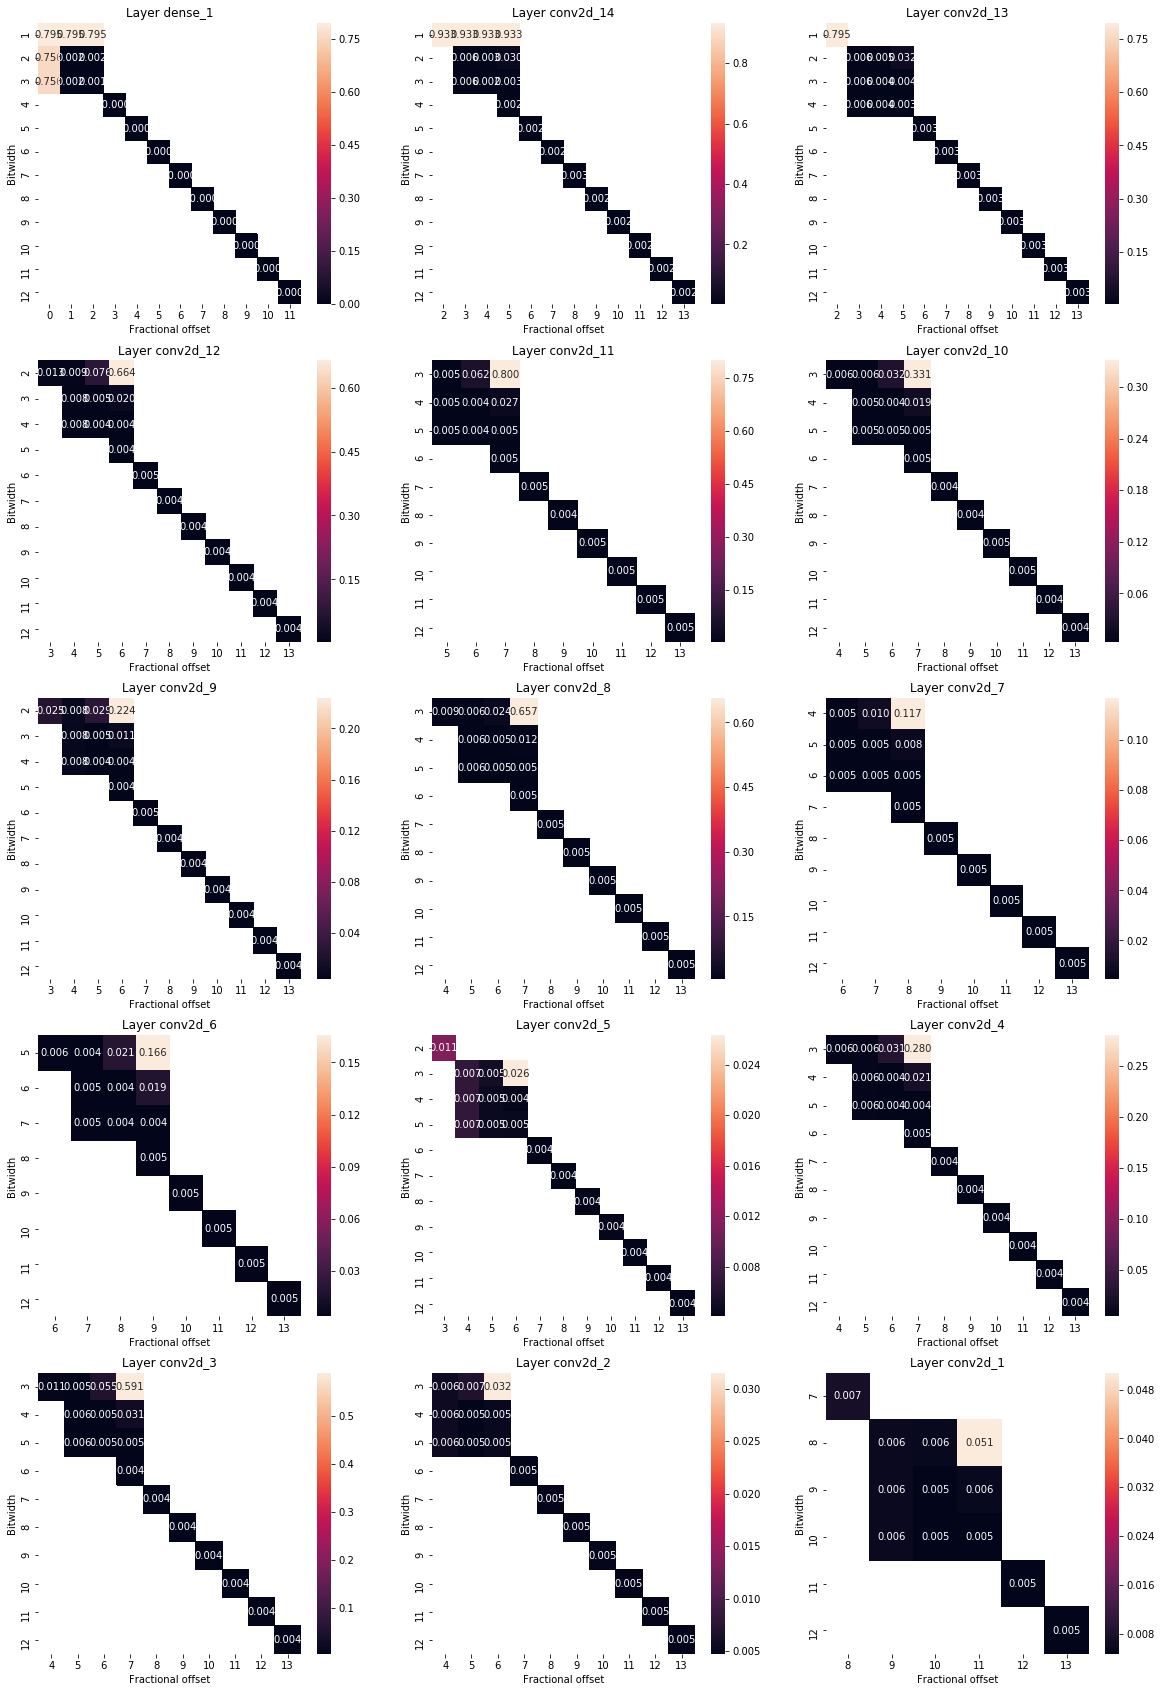

In [8]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

#### Linear

In [9]:
alloc_type = 'linear'

acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 13], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 13], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(3, 3) (3, 3) 0.0
Chosen:  (3, 3)
After quantizing layer dense_1 | Measured accuracy drop -0.0006841872258220706 | Acceptable accuracy drop: 0.0003333333333333333
Quantizing layer conv2d_14
(2, 4) (3, 4) 4.024630740122304e-05
Chosen:  (2, 4)
After quantizing layer conv2d_14 | Measured accuracy drop -0.0006036946110195083 | Acceptable accuracy drop: 0.0006666666666666666
Quantizing layer conv2d_13
(2, 3) (3, 4) 0.00044270938141426725
Chosen:  (2, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -0.00012073892220390166 | Acceptable accuracy d

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.048 %
Accuracy drop of 0.419 %


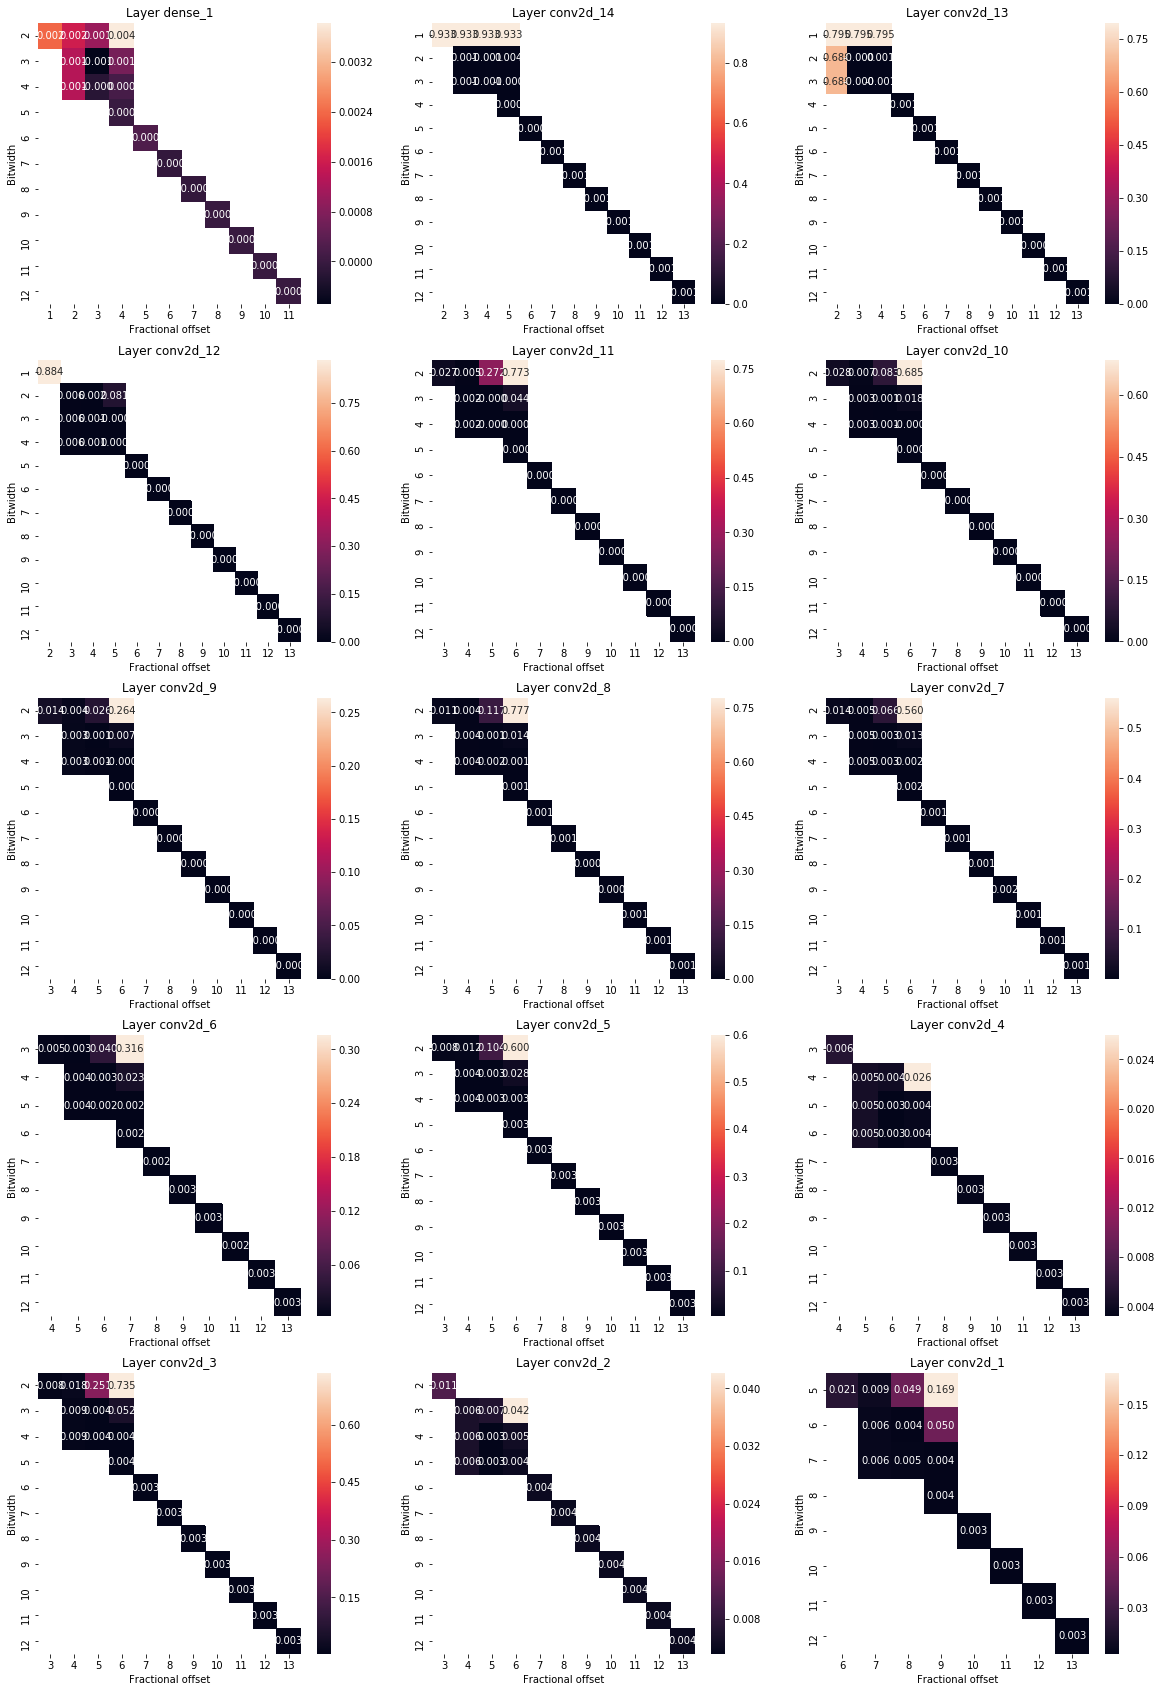

In [10]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

#### Quadratic

In [11]:
alloc_type = 'quadratic'

acc_drop_config = {
    layer_names[i - 1]: quadratic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 13], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 13], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(5, 4) (4, 3) 0.000201231537006464
Chosen:  (4, 3)
After quantizing layer dense_1 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 2.2222222222222223e-05
Quantizing layer conv2d_14
(2, 4) (2, 4) 0.0
Chosen:  (2, 4)
After quantizing layer conv2d_14 | Measured accuracy drop -0.0008451724554271954 | Acceptable accuracy drop: 8.888888888888889e-05
Quantizing layer conv2d_13
(2, 3) (3, 4) 0.0003219704592103657
Chosen:  (2, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -0.00016098522960524098 | Acceptable accuracy dro

Floating point model accuracy: 95.448 %
Quantized model accuracy: 94.972 %
Accuracy drop of 0.499 %


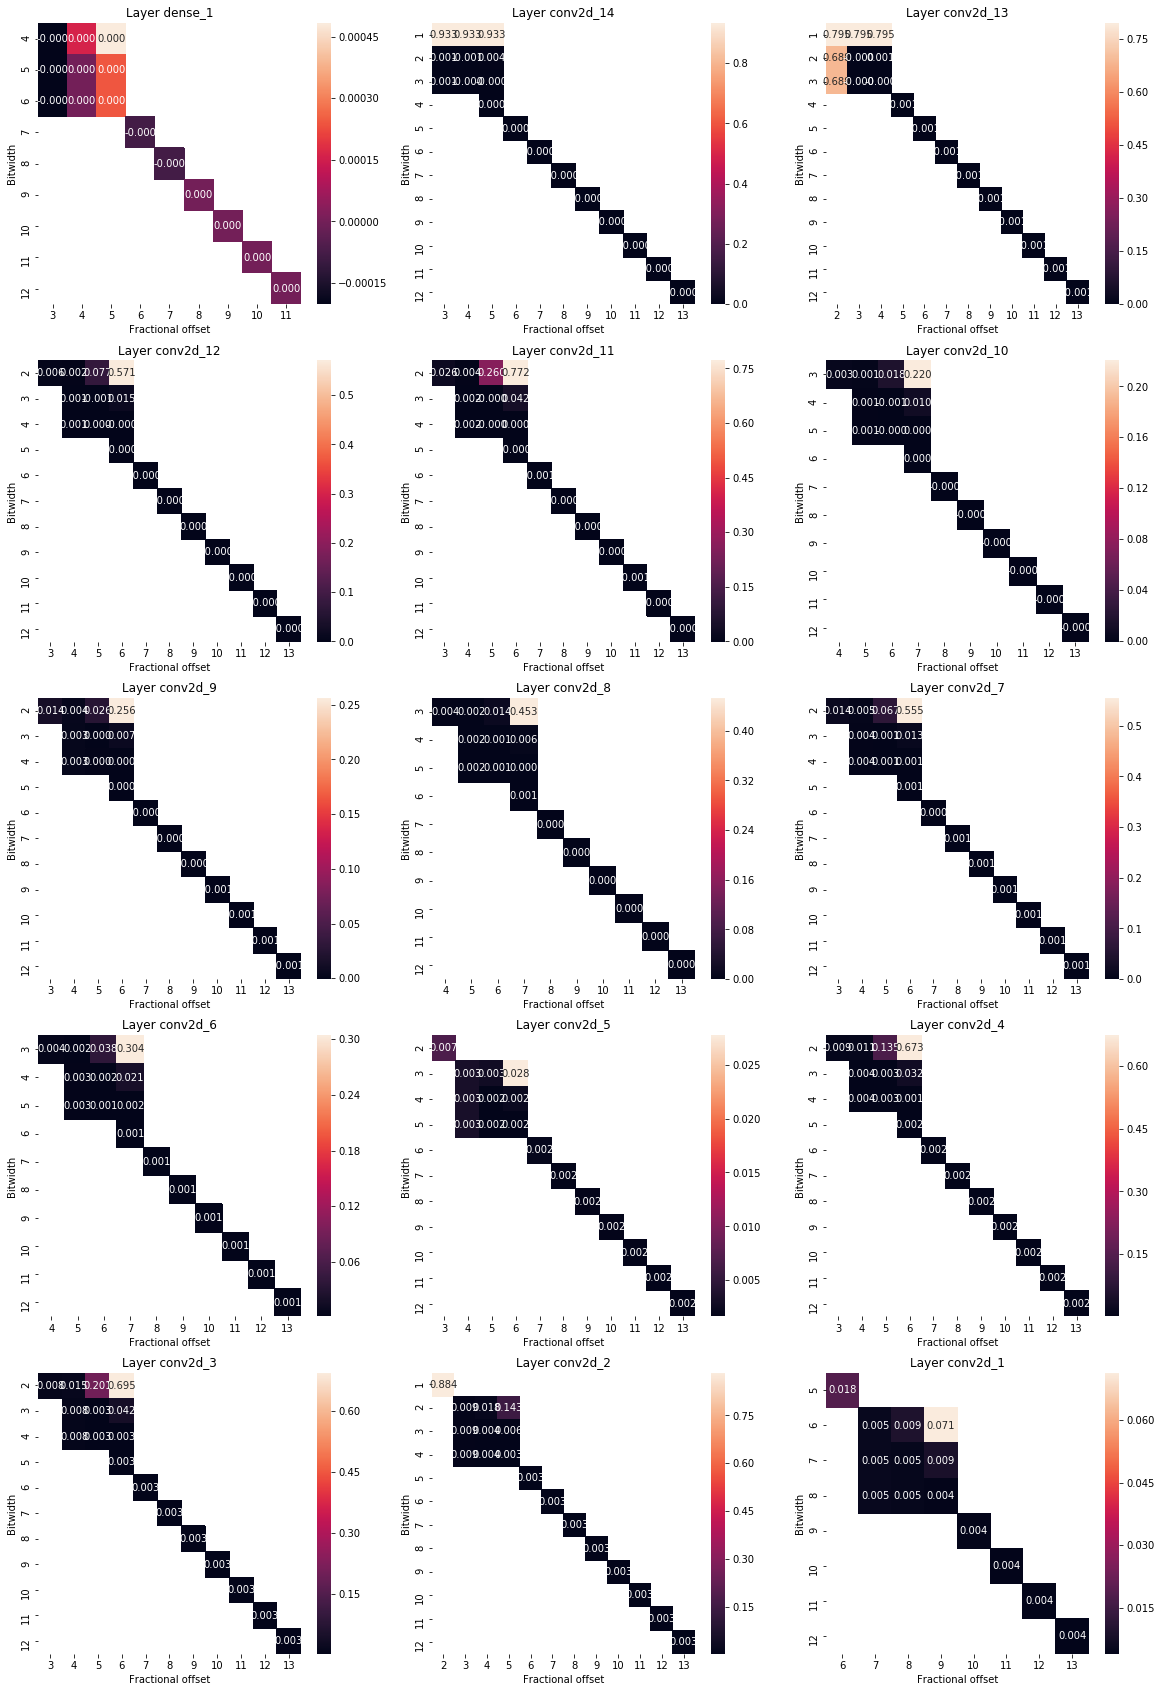

In [12]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

### Cubic

In [13]:
alloc_type = 'cubic'

acc_drop_config = {
    layer_names[i - 1]: cubic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 13], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 13], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(5, 4) (4, 3) 0.000201231537006464
Chosen:  (4, 3)
After quantizing layer dense_1 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 1.4814814814814815e-06
Quantizing layer conv2d_14
(2, 4) (2, 4) 0.0
Chosen:  (2, 4)
After quantizing layer conv2d_14 | Measured accuracy drop -0.0008451724554271954 | Acceptable accuracy drop: 1.1851851851851852e-05
Quantizing layer conv2d_13
(2, 3) (3, 4) 0.0003219704592103657
Chosen:  (2, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -0.00016098522960524098 | Acceptable accuracy dr

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.244 %
Accuracy drop of 0.213 %


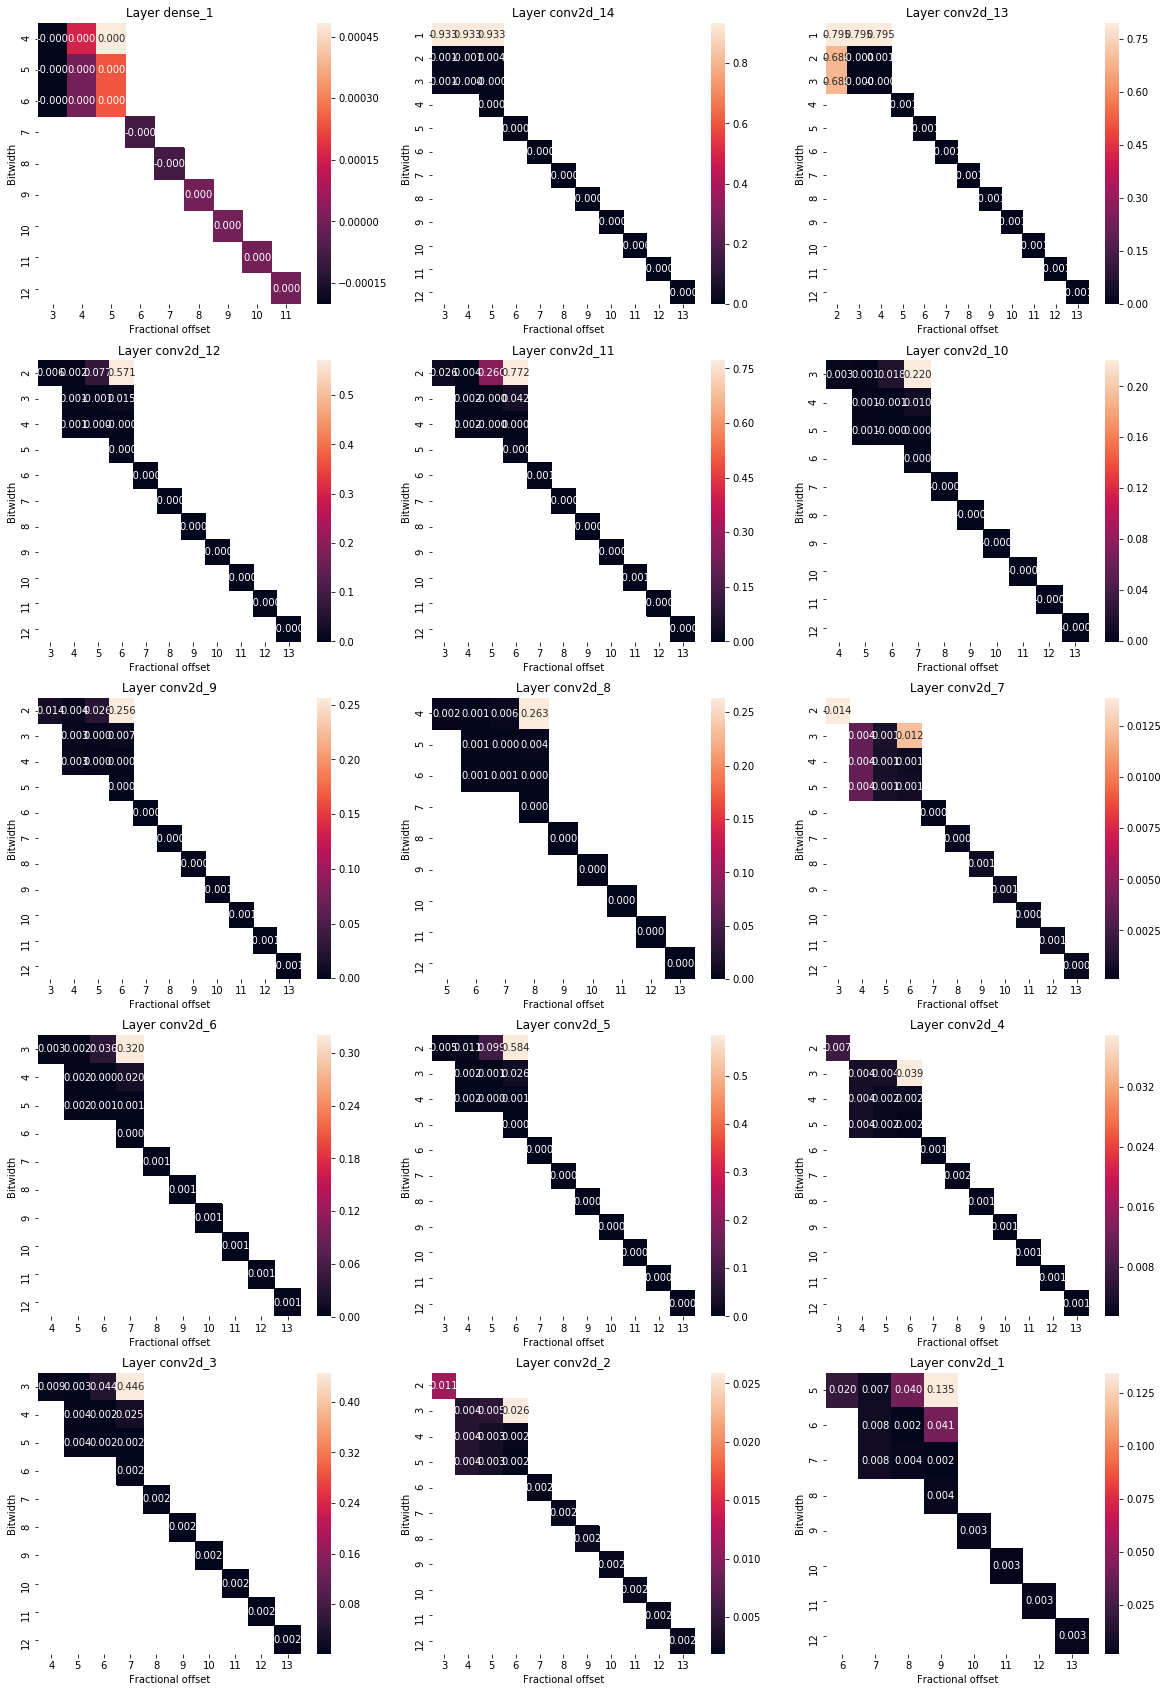

In [14]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

### Exponential

In [15]:
alloc_type = 'exponential'

acc_drop_config = {
    layer_names[i - 1]: exponential(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 13], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 13], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(5, 4) (4, 3) 0.000201231537006464
Chosen:  (4, 3)
After quantizing layer dense_1 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 3.0517578125e-07
Quantizing layer conv2d_14
(2, 4) (2, 4) 0.0
Chosen:  (2, 4)
After quantizing layer conv2d_14 | Measured accuracy drop -0.0008451724554271954 | Acceptable accuracy drop: 6.103515625e-07
Quantizing layer conv2d_13
(2, 3) (3, 4) 0.0003219704592103657
Chosen:  (2, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -0.00016098522960524098 | Acceptable accuracy drop: 1.2207031

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.056 %
Accuracy drop of 0.411 %


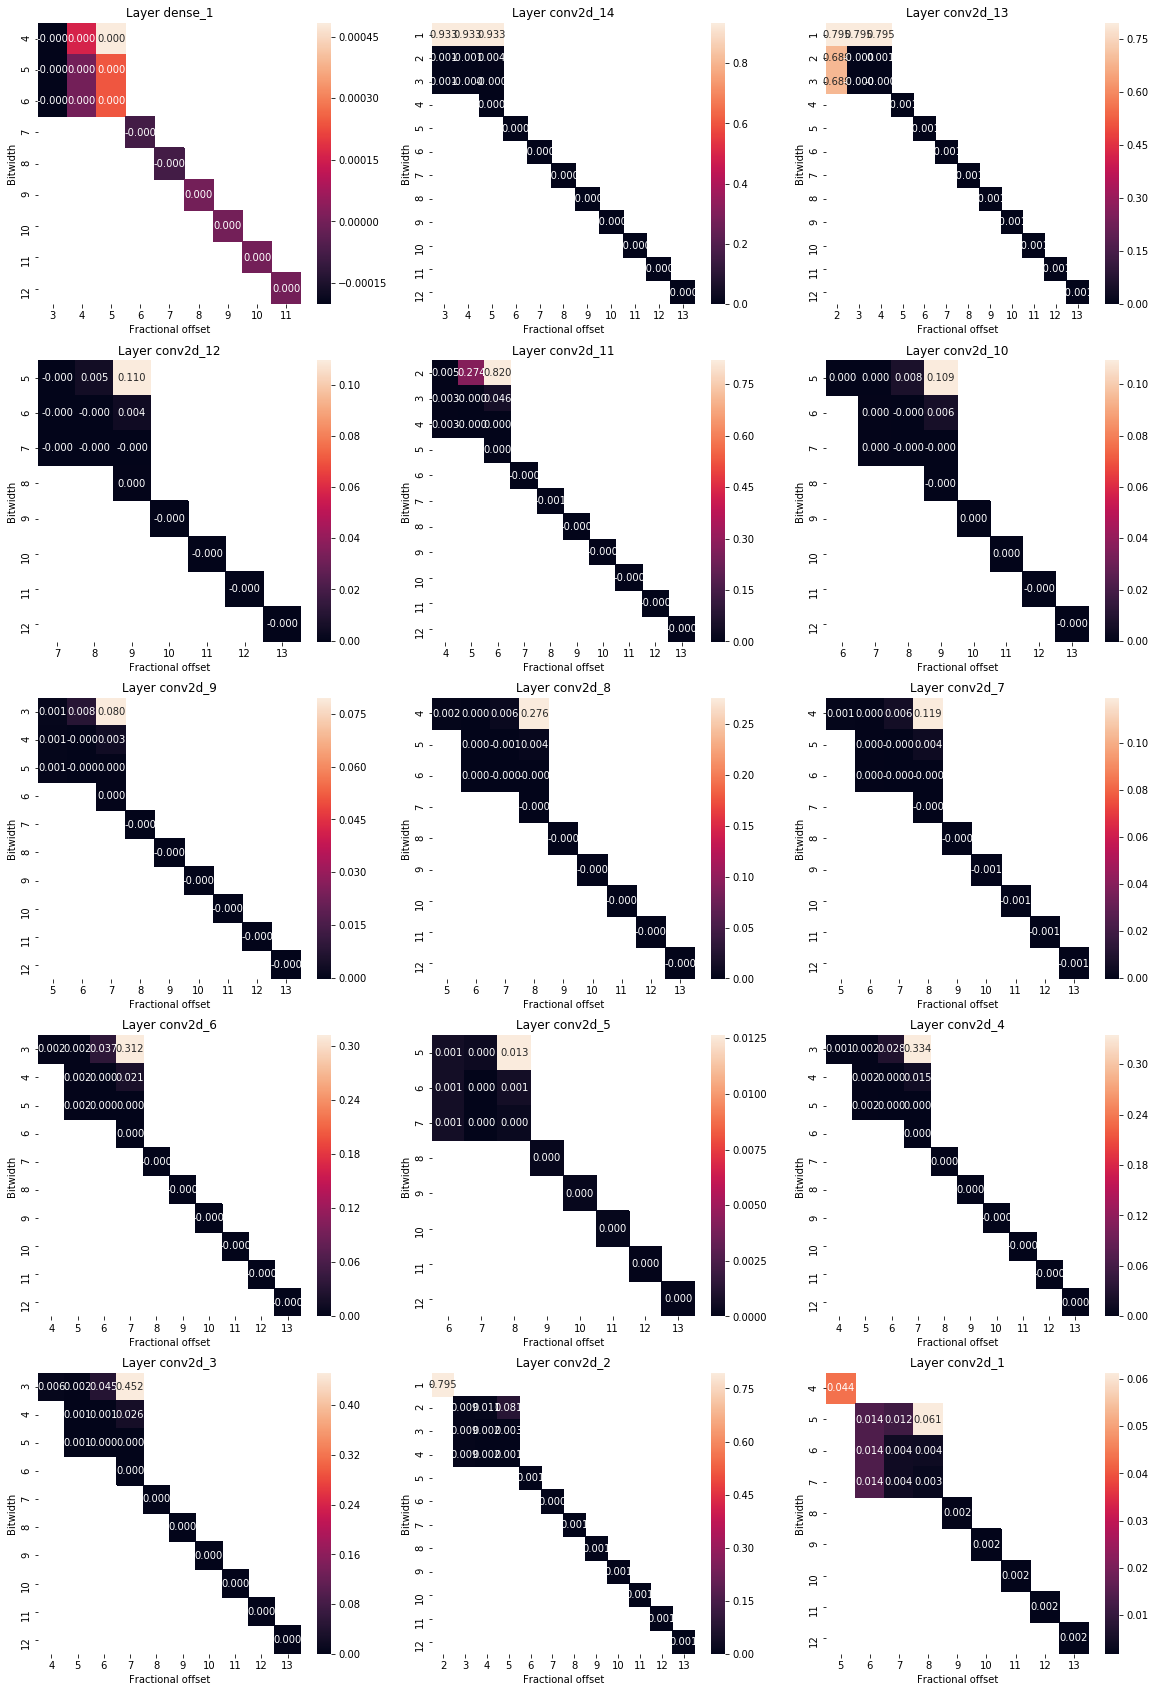

In [16]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

### Log

In [17]:
alloc_type = 'log'

acc_drop_config = {
    layer_names[i - 1]: log(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
w_scores[alloc_type], opt_params_weights[alloc_type], acc_drop_w[alloc_type] = opts.run('weights', start_bw = start_bw)

{'conv2d_1': [12, 13], 'conv2d_2': [12, 13], 'conv2d_3': [12, 13], 'conv2d_4': [12, 13], 'conv2d_5': [12, 13], 'conv2d_6': [12, 13], 'conv2d_7': [12, 13], 'conv2d_8': [12, 13], 'conv2d_9': [12, 13], 'conv2d_10': [12, 13], 'conv2d_11': [12, 13], 'conv2d_12': [12, 13], 'conv2d_13': [12, 13], 'conv2d_14': [12, 13], 'dense_1': [12, 11]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(5, 4) (4, 3) 0.000201231537006464
Chosen:  (4, 3)
After quantizing layer dense_1 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 0.0
Quantizing layer conv2d_14
(2, 4) (2, 4) 0.0
Chosen:  (2, 4)
After quantizing layer conv2d_14 | Measured accuracy drop -0.0008451724554271954 | Acceptable accuracy drop: 0.0012797901240490775
Quantizing layer conv2d_13
(2, 3) (3, 4) 0.0003219704592103657
Chosen:  (2, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -0.00016098522960524098 | Acceptable accuracy drop: 0.00202841935541

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.060 %
Accuracy drop of 0.406 %


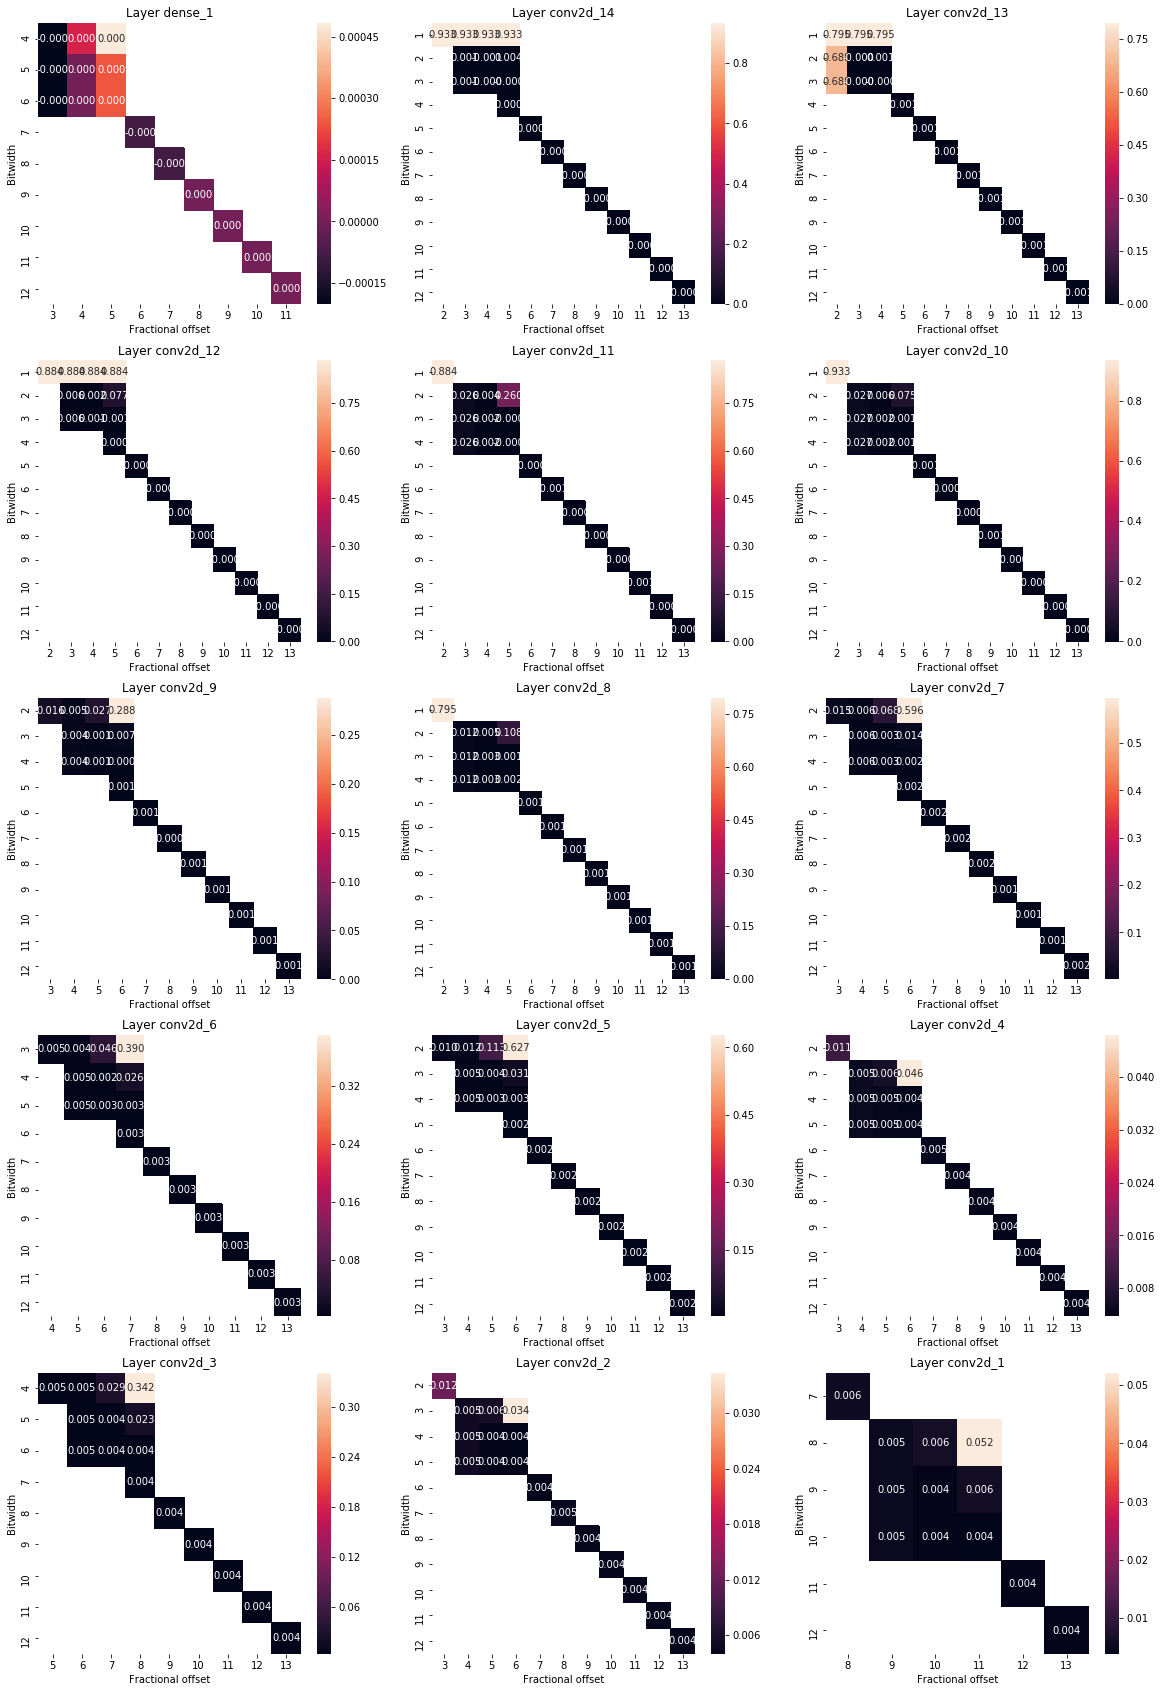

In [18]:
if not isinstance(opt_params_weights[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights[alloc_type])
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(w_scores[alloc_type], 5, 3, (20, 30))

In [19]:
with open(output_path + 'w_scores.p', 'wb') as f:
    pickle.dump(w_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f, protocol=pickle.HIGHEST_PROTOCOL)

## Observing results for the types of allocations

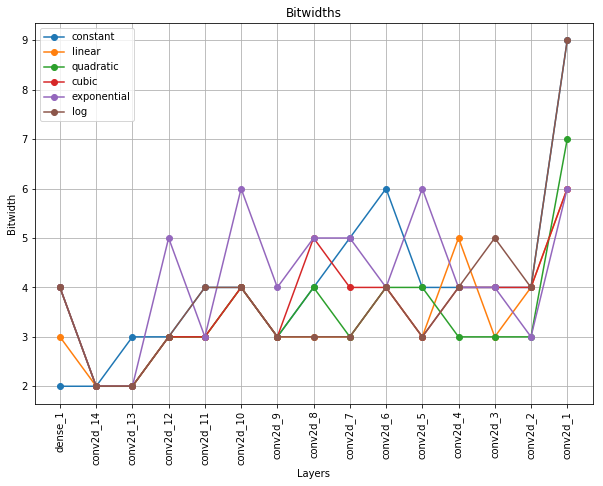

In [20]:
## Bitwidths
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in opt_params_weights:
    if isinstance(opt_params_weights[k], int):
        continue
    bw = [opt_params_weights[k][layer][0] for layer in opt_params_weights[k]]
    plt.plot(x, bw, 'o-', label=k)
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

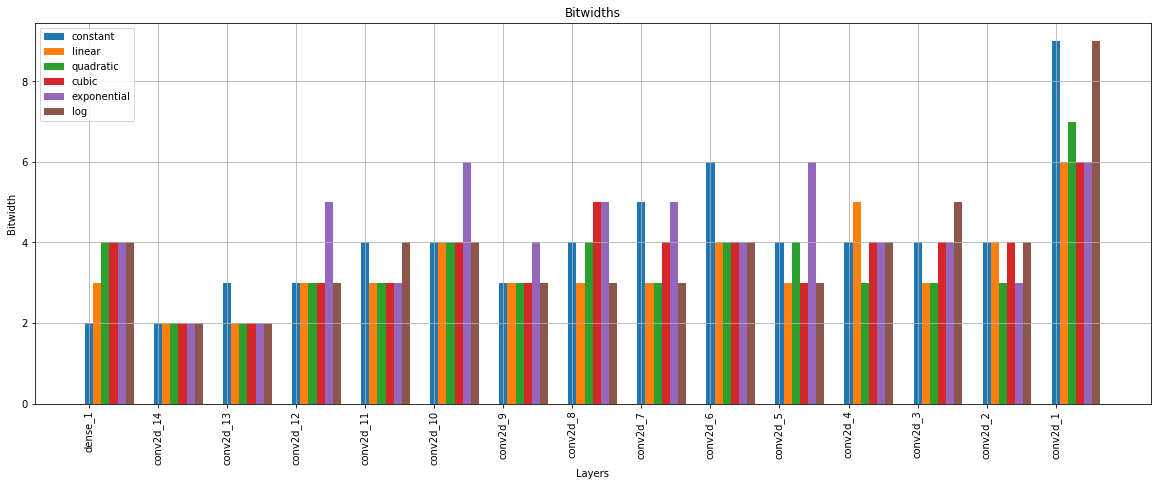

In [21]:
plt.figure(figsize=(20, 7))
width = 0.35
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(opt_params_weights.keys()):
    if isinstance(opt_params_weights[k], int):
        continue
    bw = [opt_params_weights[k][layer][0] for layer in opt_params_weights[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

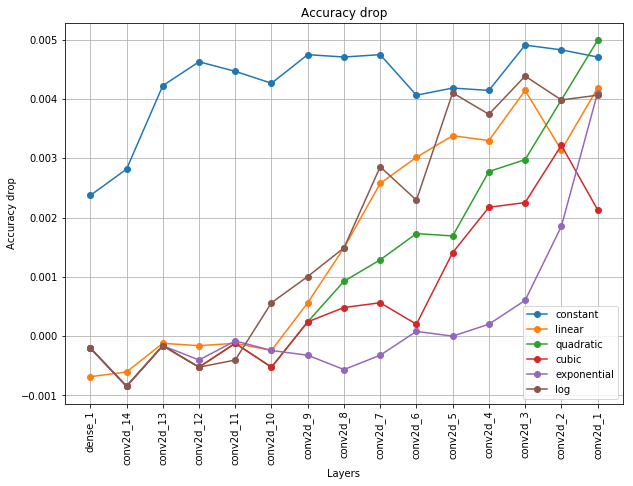

In [22]:
## Accuracy drop
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in acc_drop_w:
    if isinstance(opt_params_weights[k], int):
        continue
    plt.plot(x, acc_drop_w[k].values(), 'o-', label=k)
plt.title('Accuracy drop');
plt.xlabel('Layers');
plt.ylabel('Accuracy drop');
plt.xticks(x, layer_names, rotation='vertical');
plt.grid()
plt.legend();

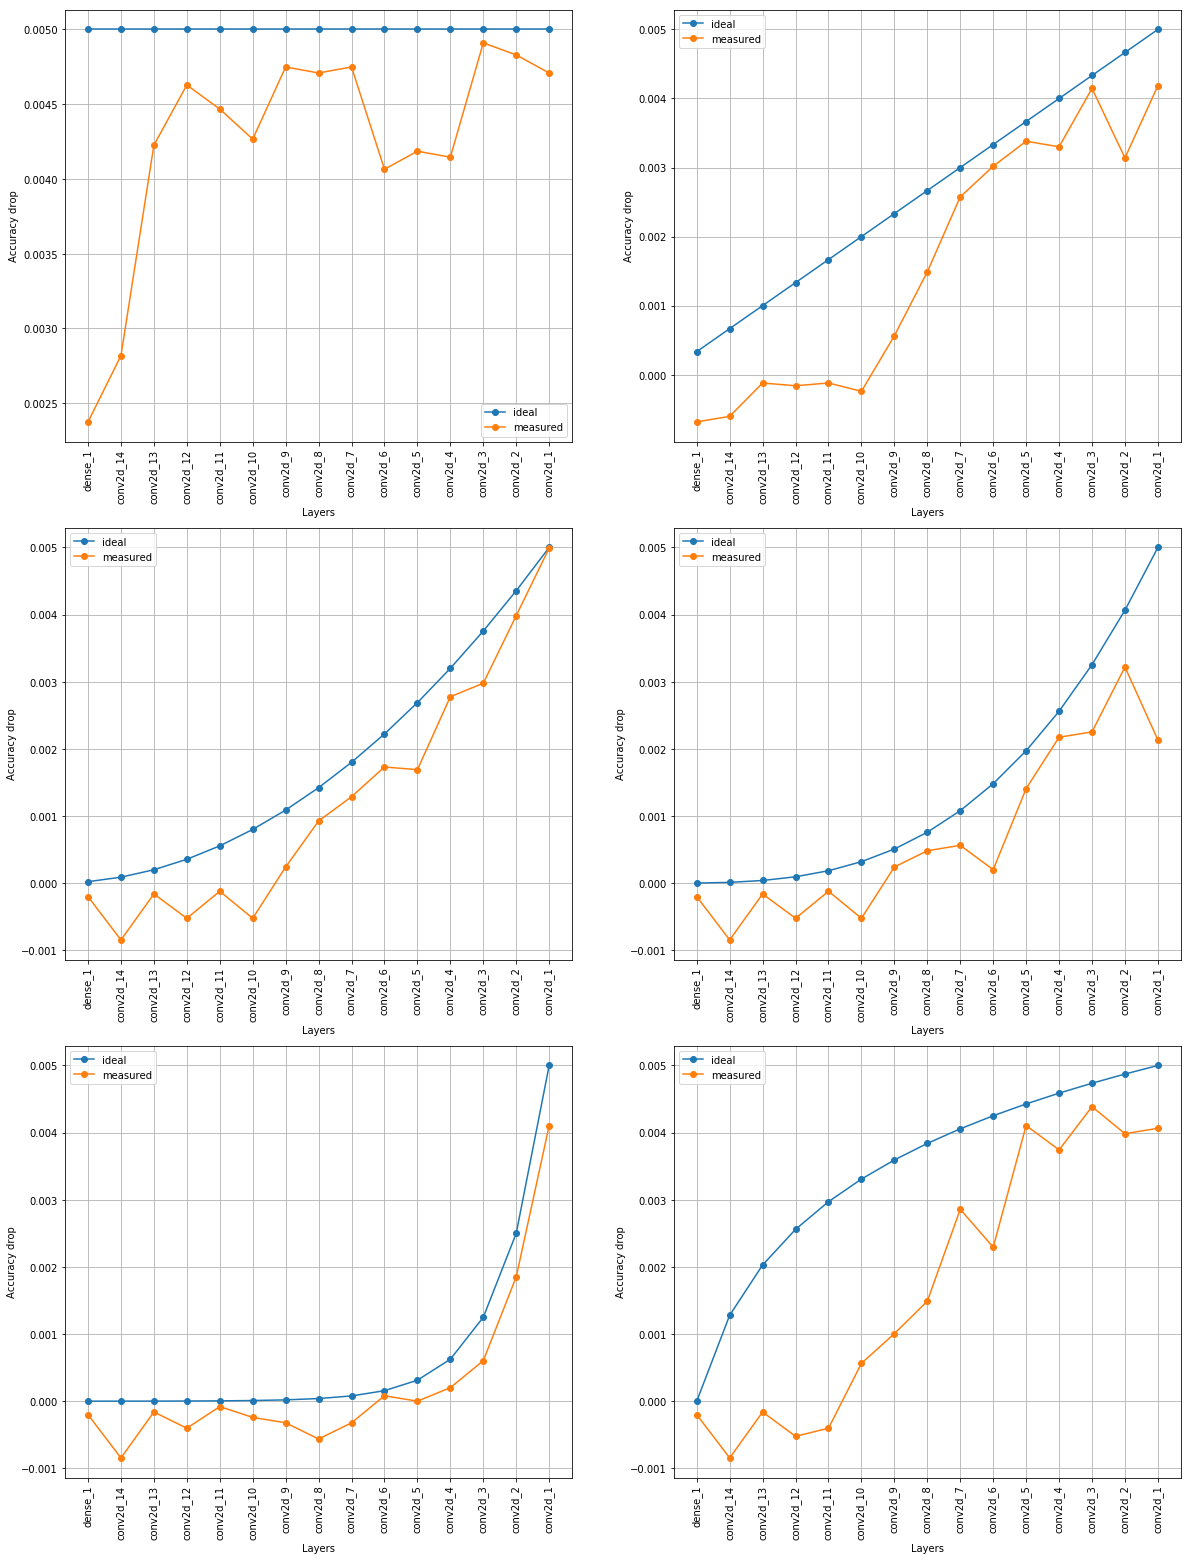

In [23]:
x = np.arange(1, 16, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = n/num_layers * x
y3 = n/num_layers**2 * x**2 # Quadratic
y4 = n/num_layers**3 * x**3 # Cubic
y5 = n/2**num_layers * 2**x # Exponential
y6 = n/np.log(num_layers) * np.log(x) # log

fig, axes = plt.subplots(3, 2, figsize=(20, 27))
ax = axes.flatten()
ax[0].plot(x, y1, 'o-', label='ideal');
ax[0].plot(x, acc_drop_w['constant'].values(), 'o-', label='measured');

ax[1].plot(x, y2, 'o-', label='ideal');
ax[1].plot(x, acc_drop_w['linear'].values(), 'o-', label='measured');

ax[2].plot(x, y3, 'o-', label='ideal');
ax[2].plot(x, acc_drop_w['quadratic'].values(), 'o-', label='measured');

ax[3].plot(x, y4, 'o-', label='ideal');
ax[3].plot(x, acc_drop_w['cubic'].values(), 'o-', label='measured');

ax[4].plot(x, y5, 'o-', label='ideal');
ax[4].plot(x, acc_drop_w['exponential'].values(), 'o-', label='measured');

ax[5].plot(x, y6, 'o-', label='ideal');
ax[5].plot(x, acc_drop_w['log'].values(), 'o-', label='measured');

for i in range(6):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    # plt.title('Accuracy drop');
    ax[i].set_xlabel('Layers');
    ax[i].set_ylabel('Accuracy drop');
    ax[i].grid();
    ax[i].legend();

In [24]:
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())

In [25]:
num_params = []
for layer in model_obj.model.layers:
    if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        w = layer.get_weights()[0]
        num_weights = len(w.flatten())
        print(layer.name, num_weights)
        num_params.append(num_weights)
num_params.reverse()
print(num_params)

conv2d_1 864
conv2d_2 9216
conv2d_3 9216
conv2d_4 9216
conv2d_5 9216
conv2d_6 9216
conv2d_7 18432
conv2d_8 36864
conv2d_9 36864
conv2d_10 36864
conv2d_11 36864
conv2d_12 36864
conv2d_13 36864
conv2d_14 36864
dense_1 640
[640, 36864, 36864, 36864, 36864, 36864, 36864, 36864, 18432, 9216, 9216, 9216, 9216, 9216, 864]


In [26]:
total_memory = {}
for k in opt_params_weights:
    if isinstance(opt_params_weights[k], int):
        continue
    bw = [opt_params_weights[k][layer][0] for layer in opt_params_weights[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_MB = [i/(8*1024**2) for i in memory_consumption]

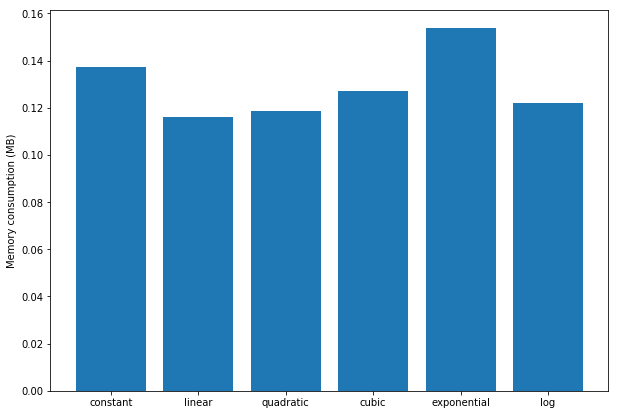

In [27]:
plt.figure(figsize=(10, 7))
plt.bar(np.arange(1, len(memory_consumption_MB) + 1, 1), memory_consumption_MB);
plt.xticks(np.arange(1, len(memory_consumption_MB) + 1, 1), total_memory.keys(), rotation='horizontal');
plt.ylabel('Memory consumption (MB)');

# Activations

In [28]:
start_bw = 16
a_scores = {}
opt_params_act = {}
acc_drop_a = {}

In [29]:
alloc_type = 'constant'

acc_drop_config = {
    layer: 0.005 for layer in layer_names
}
opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 16], 'conv2d_2': [16, 11], 'conv2d_3': [16, 11], 'conv2d_4': [16, 11], 'conv2d_5': [16, 10], 'conv2d_6': [16, 11], 'conv2d_7': [16, 11], 'conv2d_8': [16, 11], 'conv2d_9': [16, 10], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 11], 'conv2d_13': [16, 10], 'conv2d_14': [16, 11], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(3, -1) (4, 0) 0.001690344910854391
Chosen:  (4, 0)
After quantizing layer dense_1 | Measured accuracy drop 0.0004427093814142673 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_14
(2, -1) (3, 0) 0.0009659113776310969
Chosen:  (2, -1)
After quantizing layer conv2d_14 | Measured accuracy drop 0.001569605988650489 | Acceptable accuracy drop: 0.005
Quantizing layer conv2d_13
(3, -1) (4, 0) 0.0016903449108543905
Chosen:  (4, 0)
After quantizing layer conv2d_13 | Measured accuracy drop 0.0016500986034531677 | Acceptable accuracy drop: 0.005
Quanti

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.048 %
Accuracy drop of 0.419 %


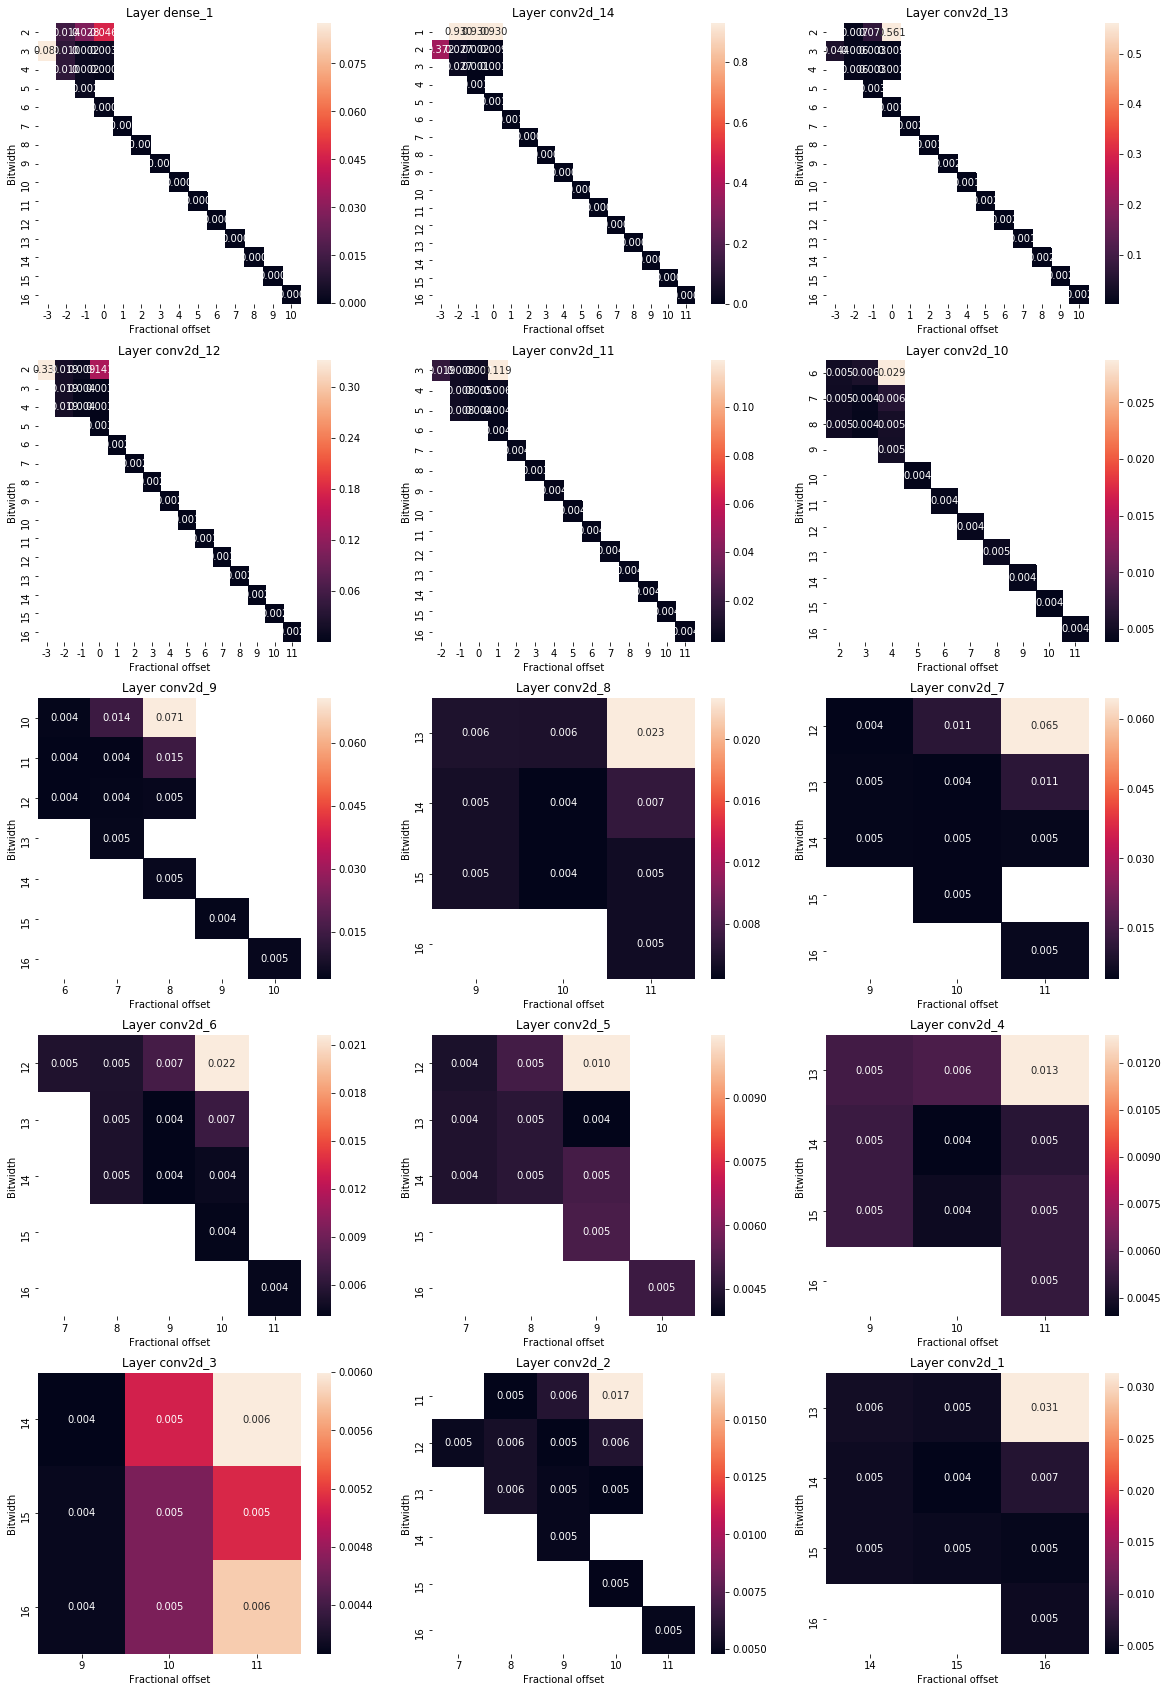

In [30]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

#### Linear

In [31]:
alloc_type = 'linear'

acc_drop_config = {
    layer_names[i - 1]: linear(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 16], 'conv2d_2': [16, 11], 'conv2d_3': [16, 11], 'conv2d_4': [16, 11], 'conv2d_5': [16, 10], 'conv2d_6': [16, 11], 'conv2d_7': [16, 11], 'conv2d_8': [16, 11], 'conv2d_9': [16, 10], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 11], 'conv2d_13': [16, 10], 'conv2d_14': [16, 11], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(4, 1) (5, 1) 0.00044270938141415103
Chosen:  (4, 1)
After quantizing layer dense_1 | Measured accuracy drop 0.00016098522960512467 | Acceptable accuracy drop: 0.0003333333333333333
Quantizing layer conv2d_14
(4, 1) (4, 1) 0.0
Chosen:  (4, 1)
After quantizing layer conv2d_14 | Measured accuracy drop -4.024630740133933e-05 | Acceptable accuracy drop: 0.0006666666666666666
Quantizing layer conv2d_13
(3, -1) (4, 0) 0.000402463074012928
Chosen:  (3, -1)
After quantizing layer conv2d_13 | Measured accuracy drop 0.0005232019962168297 | Acceptable accuracy dr

Floating point model accuracy: 95.448 %
Quantized model accuracy: 94.972 %
Accuracy drop of 0.499 %


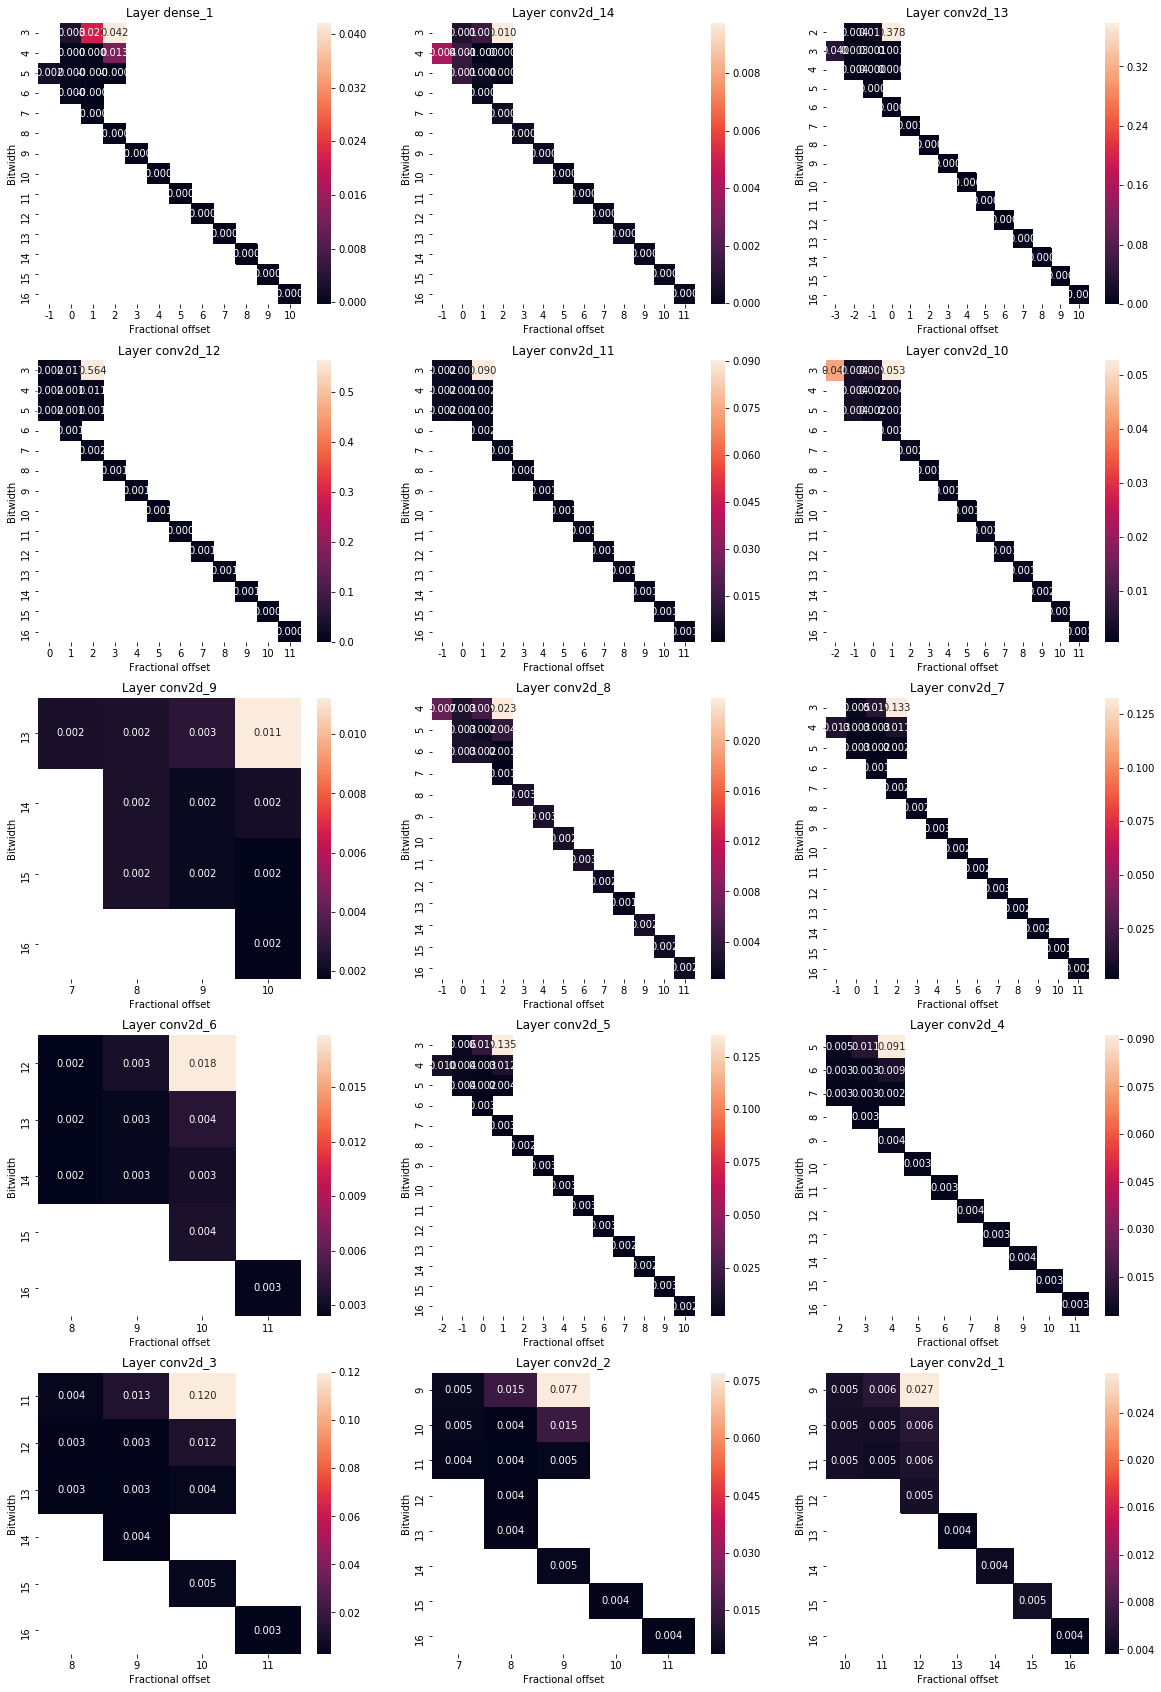

In [32]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

#### Quadratic

In [33]:
alloc_type = 'quadratic'

acc_drop_config = {
    layer_names[i - 1]: quadratic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 16], 'conv2d_2': [16, 11], 'conv2d_3': [16, 11], 'conv2d_4': [16, 11], 'conv2d_5': [16, 10], 'conv2d_6': [16, 11], 'conv2d_7': [16, 11], 'conv2d_8': [16, 11], 'conv2d_9': [16, 10], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 11], 'conv2d_13': [16, 10], 'conv2d_14': [16, 11], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(6, 3) (6, 2) 0.00012073892220378538
Chosen:  (6, 2)
After quantizing layer dense_1 | Measured accuracy drop -0.00028172415180902636 | Acceptable accuracy drop: 2.2222222222222223e-05
Quantizing layer conv2d_14
(4, 1) (4, 1) 0.0
Chosen:  (4, 1)
After quantizing layer conv2d_14 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 8.888888888888889e-05
Quantizing layer conv2d_13
(7, 3) (8, 3) 4.024630740122301e-05
Chosen:  (7, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -4.024630740133933e-05 | Acceptable accuracy d

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.098 %
Accuracy drop of 0.366 %


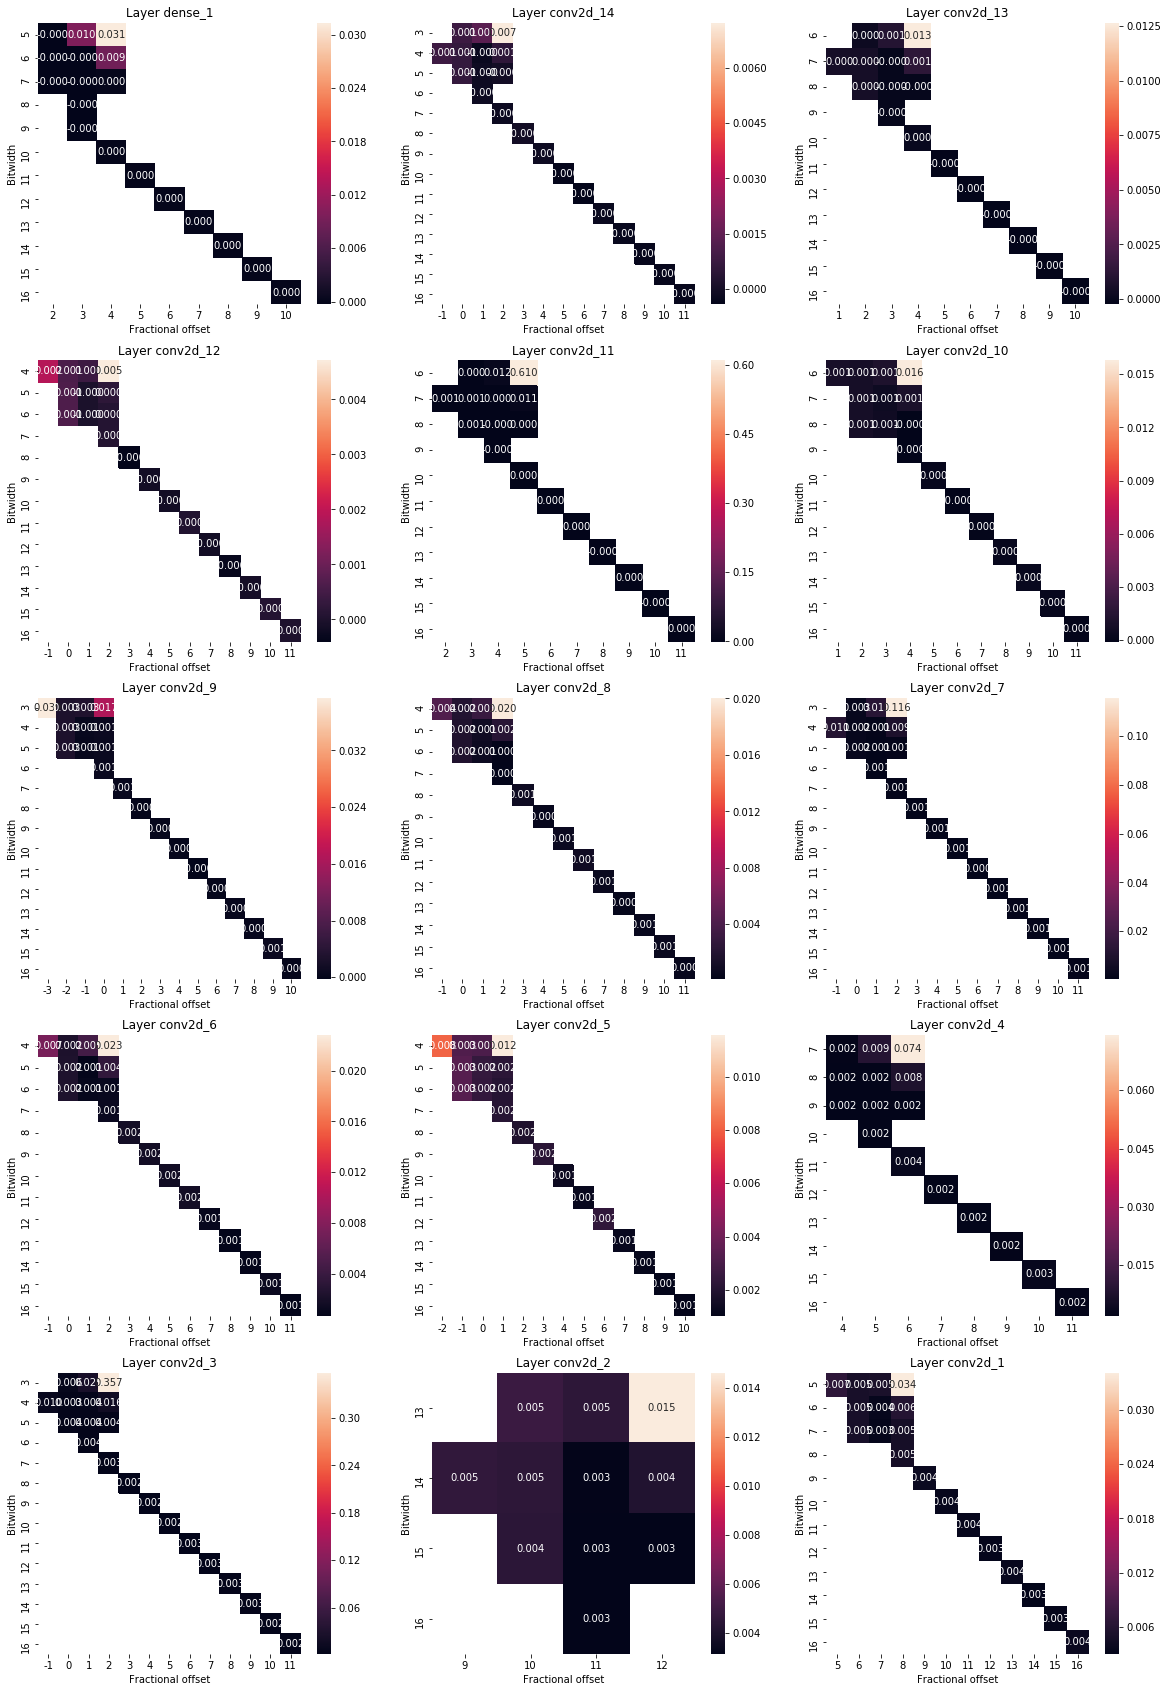

In [34]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

### Cubic

In [35]:
alloc_type = 'cubic'
acc_drop_config = {
    layer_names[i - 1]: cubic(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 16], 'conv2d_2': [16, 11], 'conv2d_3': [16, 11], 'conv2d_4': [16, 11], 'conv2d_5': [16, 10], 'conv2d_6': [16, 11], 'conv2d_7': [16, 11], 'conv2d_8': [16, 11], 'conv2d_9': [16, 10], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 11], 'conv2d_13': [16, 10], 'conv2d_14': [16, 11], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(6, 3) (6, 2) 0.00012073892220378538
Chosen:  (6, 2)
After quantizing layer dense_1 | Measured accuracy drop -0.00028172415180902636 | Acceptable accuracy drop: 1.4814814814814815e-06
Quantizing layer conv2d_14
(4, 1) (4, 1) 0.0
Chosen:  (4, 1)
After quantizing layer conv2d_14 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 1.1851851851851852e-05
Quantizing layer conv2d_13
(7, 3) (8, 3) 4.024630740122301e-05
Chosen:  (7, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -4.024630740133933e-05 | Acceptable accuracy 

Floating point model accuracy: 95.448 %
Quantized model accuracy: 94.998 %
Accuracy drop of 0.471 %


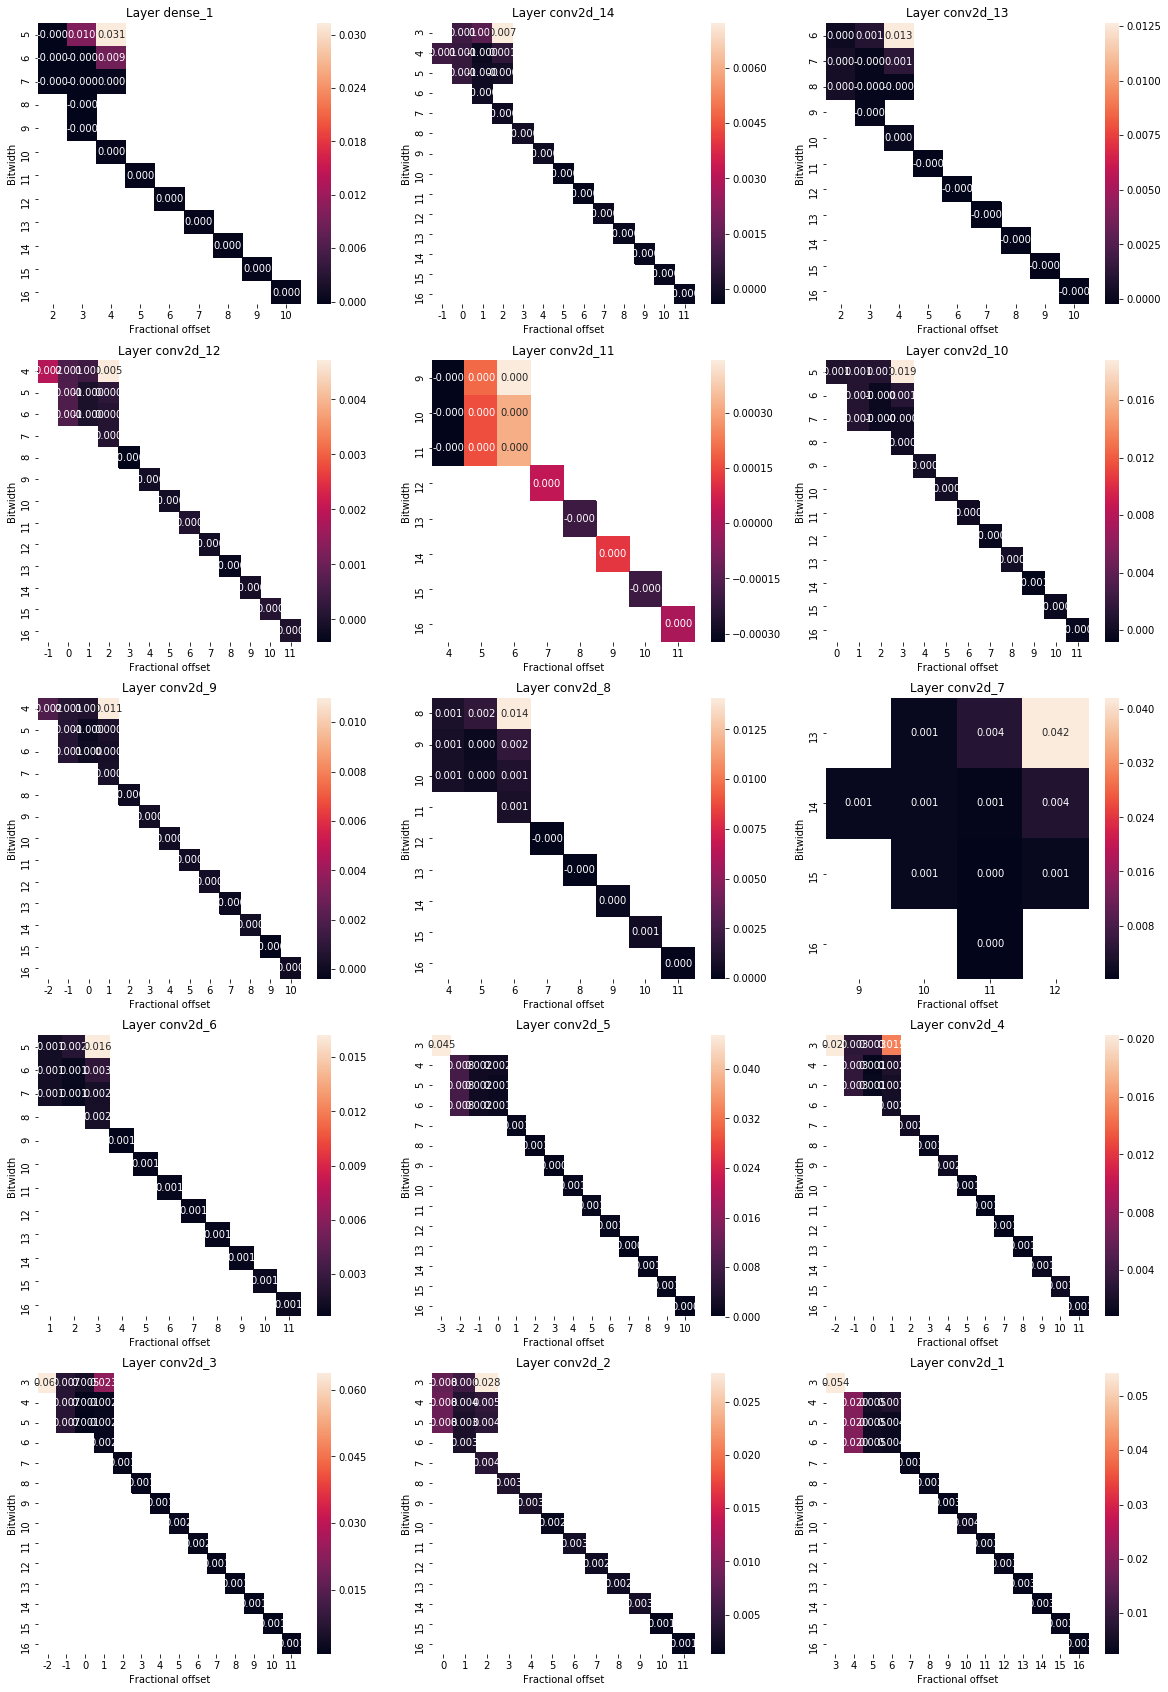

In [36]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

### Exponential

In [37]:
alloc_type = 'exponential'

acc_drop_config = {
    layer_names[i - 1]: exponential(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 16], 'conv2d_2': [16, 11], 'conv2d_3': [16, 11], 'conv2d_4': [16, 11], 'conv2d_5': [16, 10], 'conv2d_6': [16, 11], 'conv2d_7': [16, 11], 'conv2d_8': [16, 11], 'conv2d_9': [16, 10], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 11], 'conv2d_13': [16, 10], 'conv2d_14': [16, 11], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(6, 3) (6, 2) 0.00012073892220378538
Chosen:  (6, 2)
After quantizing layer dense_1 | Measured accuracy drop -0.00028172415180902636 | Acceptable accuracy drop: 3.0517578125e-07
Quantizing layer conv2d_14
(4, 1) (4, 1) 0.0
Chosen:  (4, 1)
After quantizing layer conv2d_14 | Measured accuracy drop -0.000201231537006464 | Acceptable accuracy drop: 6.103515625e-07
Quantizing layer conv2d_13
(7, 3) (8, 3) 4.024630740122301e-05
Chosen:  (7, 3)
After quantizing layer conv2d_13 | Measured accuracy drop -4.024630740133933e-05 | Acceptable accuracy drop: 1.22070

In [38]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

### Log

In [39]:
alloc_type = 'log'

acc_drop_config = {
    layer_names[i - 1]: log(i, total_acc_drop, len(layer_names)) for i in range(1, len(layer_names) + 1)
}

opts = OptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc)
a_scores[alloc_type], opt_params_act[alloc_type], acc_drop_a[alloc_type] = opts.run('activations', start_bw = start_bw)

{'conv2d_1': [16, 16], 'conv2d_2': [16, 11], 'conv2d_3': [16, 11], 'conv2d_4': [16, 11], 'conv2d_5': [16, 10], 'conv2d_6': [16, 11], 'conv2d_7': [16, 11], 'conv2d_8': [16, 11], 'conv2d_9': [16, 10], 'conv2d_10': [16, 11], 'conv2d_11': [16, 11], 'conv2d_12': [16, 11], 'conv2d_13': [16, 10], 'conv2d_14': [16, 11], 'dense_1': [16, 10]}
Finding quantization for each layer depending on quantization for previous layers
Quantizing layer dense_1
(6, 3) (6, 2) 0.00012073892220378538
Chosen:  (6, 2)
After quantizing layer dense_1 | Measured accuracy drop -0.00028172415180902636 | Acceptable accuracy drop: 0.0
Quantizing layer conv2d_14
(3, -1) (4, 0) 0.000201231537006464
Chosen:  (3, -1)
After quantizing layer conv2d_14 | Measured accuracy drop 0.0008451724554271954 | Acceptable accuracy drop: 0.0012797901240490775
Quantizing layer conv2d_13
(4, 0) (4, 0) 0.0
Chosen:  (4, 0)
After quantizing layer conv2d_13 | Measured accuracy drop 0.000804926148025856 | Acceptable accuracy drop: 0.0020284193554

Floating point model accuracy: 95.448 %
Quantized model accuracy: 95.087 %
Accuracy drop of 0.378 %


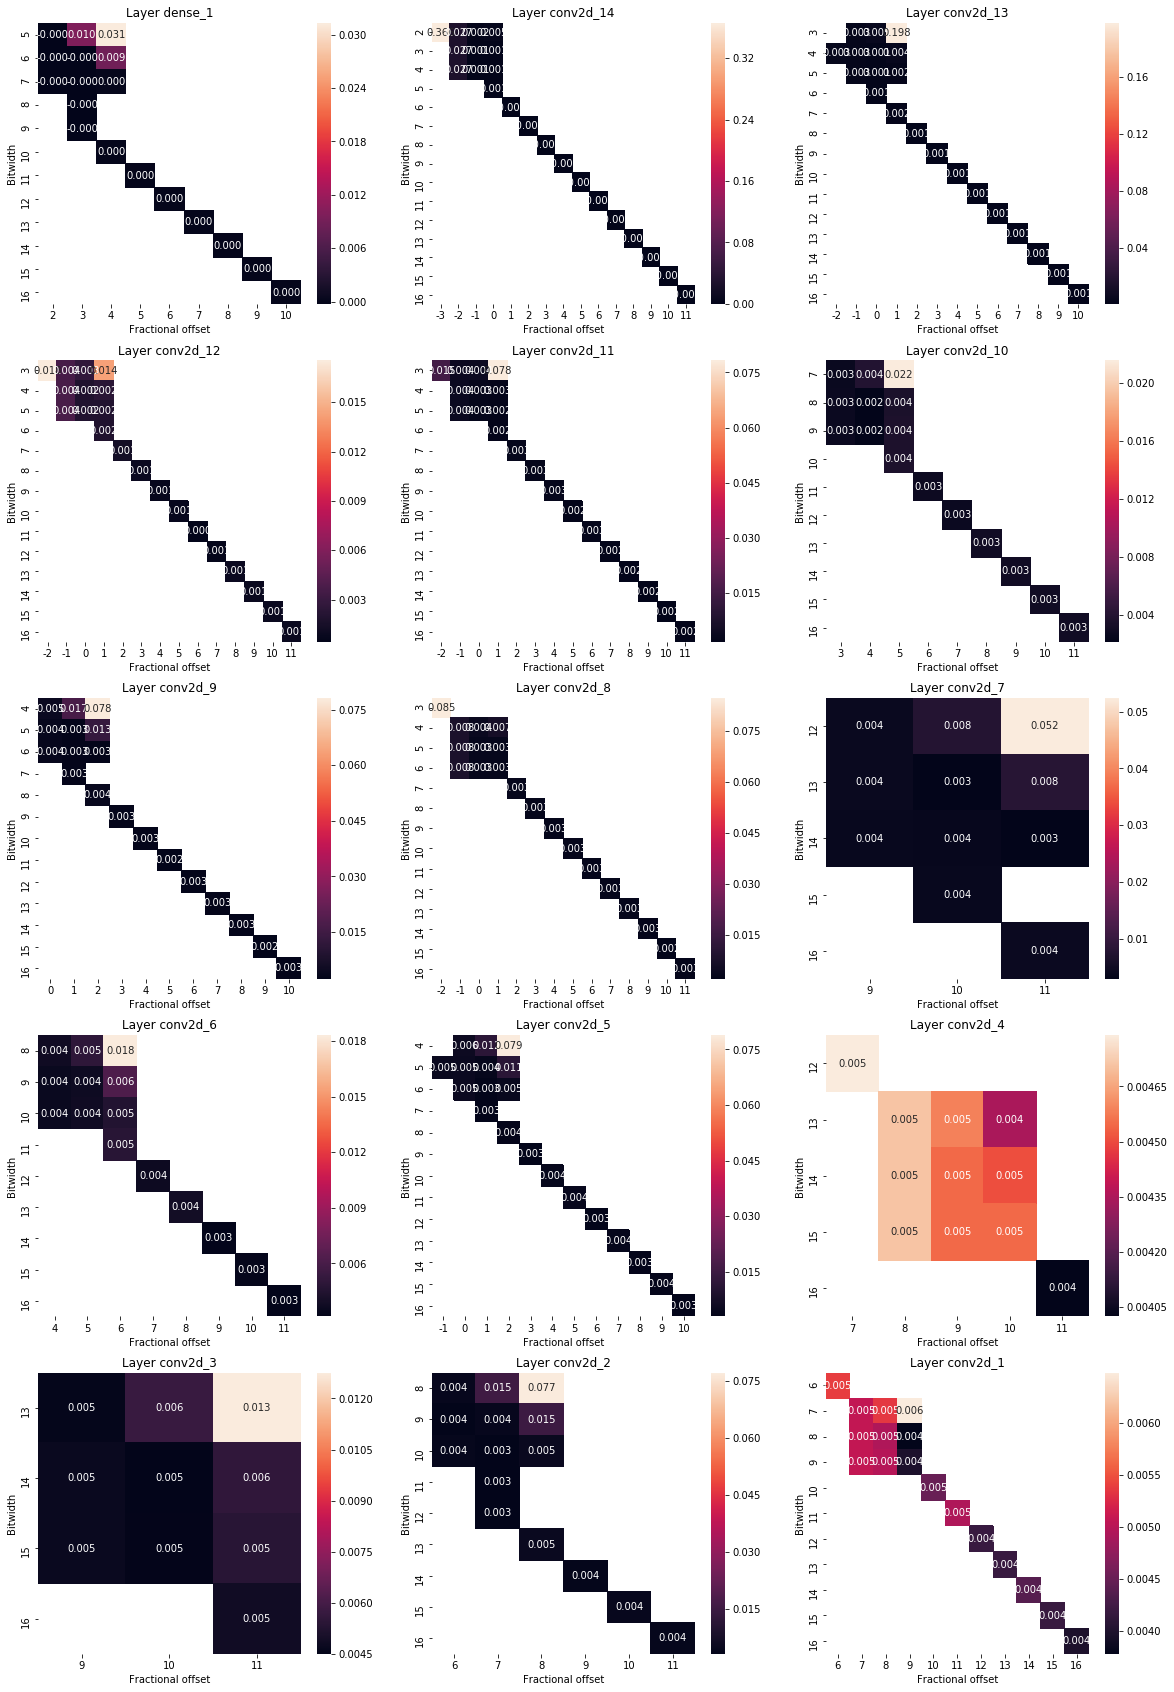

In [40]:
if not isinstance(opt_params_act[alloc_type], int):
    print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

    model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act[alloc_type]))
    fxp_model_acc = model_obj.evaluate_accuracy()[1]
    print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
    print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

    opts.plot_scores_matrix(a_scores[alloc_type], 5, 3, (20, 30))

In [41]:
with open(output_path + 'a_scores.p', 'wb') as f:
    pickle.dump(a_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(output_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f, protocol=pickle.HIGHEST_PROTOCOL)

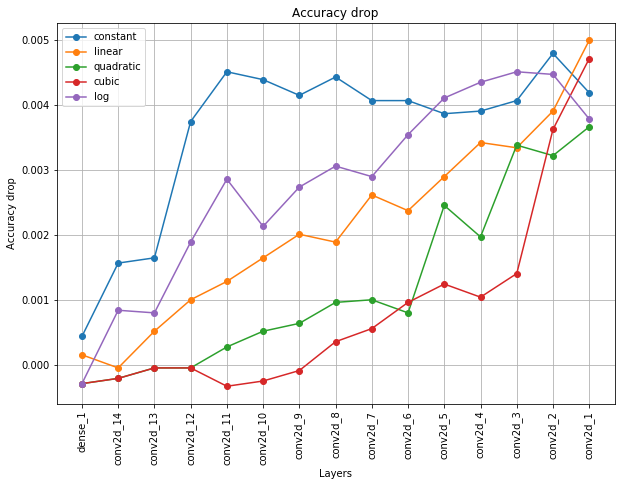

In [42]:
## Accuracy drop
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in acc_drop_a:
    if isinstance(acc_drop_a[k], int):
        continue
    plt.plot(x, acc_drop_a[k].values(), 'o-', label=k)
plt.title('Accuracy drop');
plt.xlabel('Layers');
plt.ylabel('Accuracy drop');
plt.xticks(x, layer_names, rotation='vertical')
plt.grid()
plt.legend();

AttributeError: 'int' object has no attribute 'values'

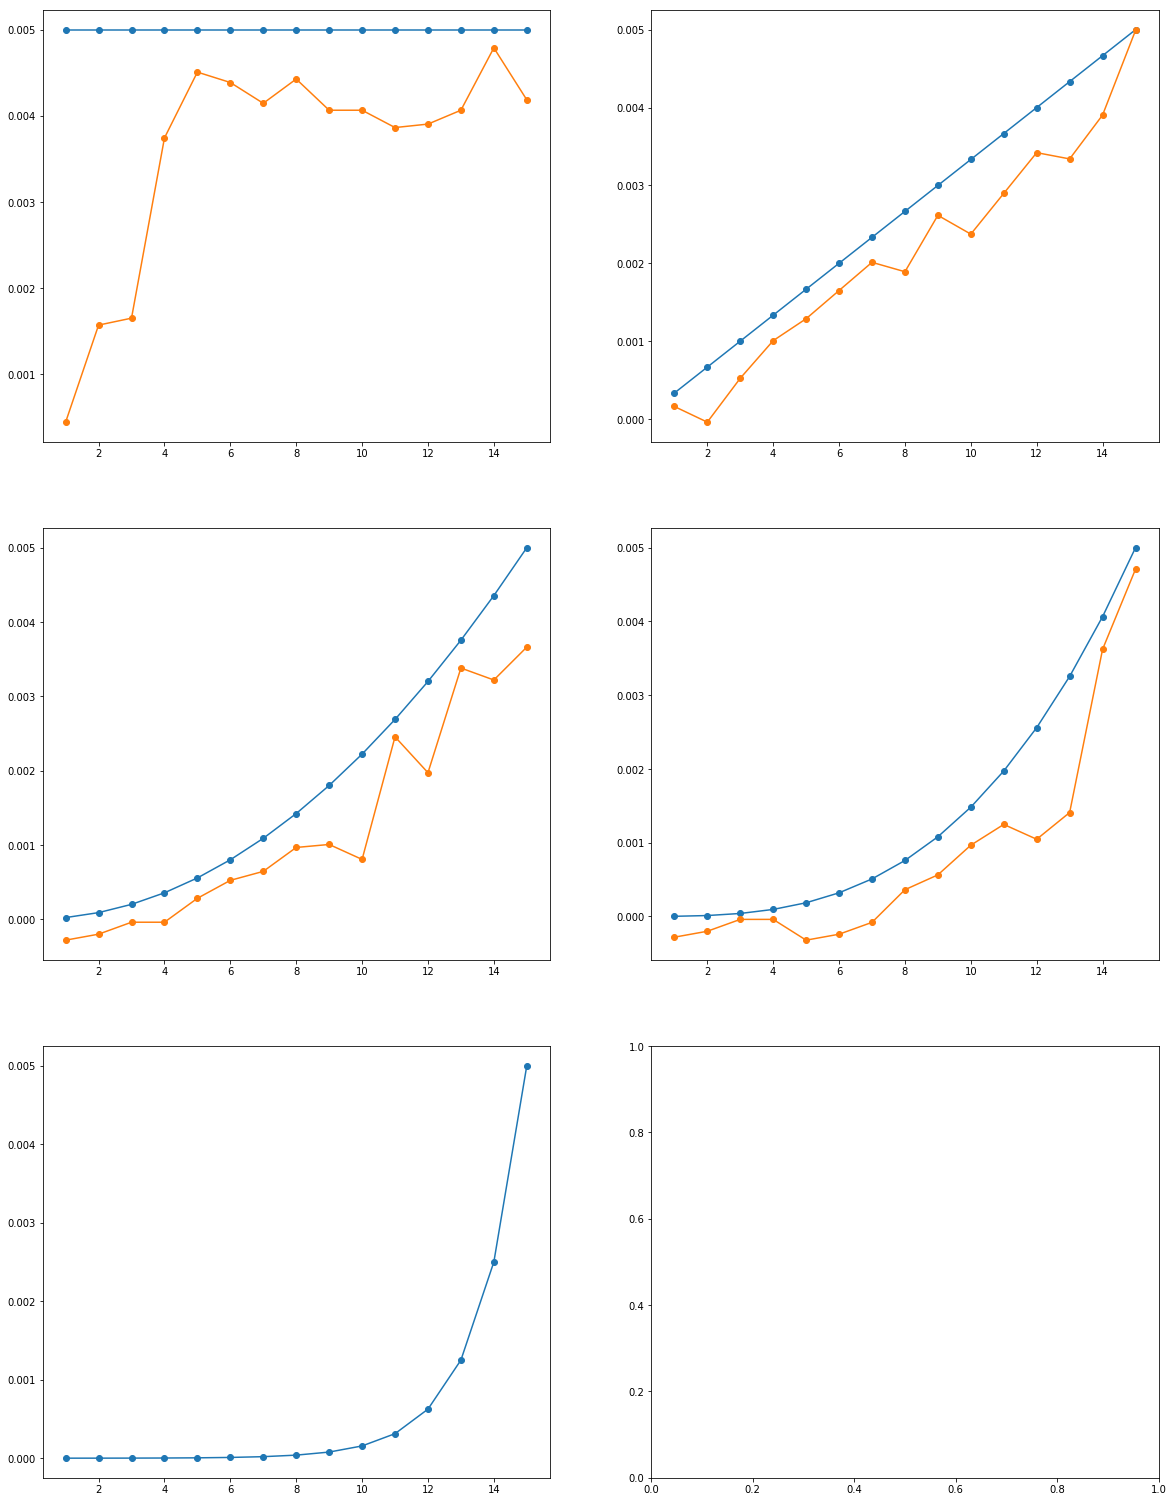

In [43]:
x = np.arange(1, 16, 1)
num_layers = len(x)
n = 0.005 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = n/num_layers * x
y3 = n/num_layers**2 * x**2 # Quadratic
y4 = n/num_layers**3 * x**3 # Cubic
y5 = n/2**num_layers * 2**x # Exponential
y6 = n/np.log(num_layers) * np.log(x) # log

fig, axes = plt.subplots(3, 2, figsize=(20, 27))
ax = axes.flatten()
ax[0].plot(x, y1, 'o-', label='ideal');
ax[0].plot(x, acc_drop_a['constant'].values(), 'o-', label='measured');

ax[1].plot(x, y2, 'o-', label='ideal');
ax[1].plot(x, acc_drop_a['linear'].values(), 'o-', label='measured');

ax[2].plot(x, y3, 'o-', label='ideal');
ax[2].plot(x, acc_drop_a['quadratic'].values(), 'o-', label='measured');

ax[3].plot(x, y4, 'o-', label='ideal');
ax[3].plot(x, acc_drop_a['cubic'].values(), 'o-', label='measured');

ax[4].plot(x, y5, 'o-', label='ideal');
ax[4].plot(x, acc_drop_a['exponential'].values(), 'o-', label='measured');

ax[5].plot(x, y6, 'o-', label='ideal');
ax[5].plot(x, acc_drop_a['log'].values(), 'o-', label='measured');

for i in range(6):
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(layer_names, rotation=90)
    # plt.title('Accuracy drop');
    ax[i].set_xlabel('Layers');
    ax[i].set_ylabel('Accuracy drop');
    ax[i].grid();
    ax[i].legend();

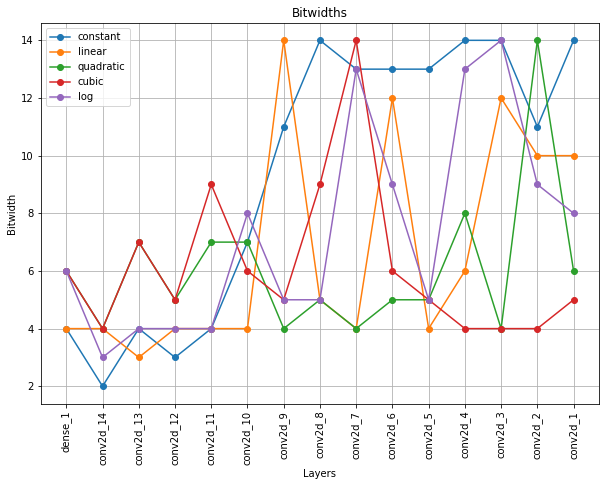

In [44]:
## Bitwidths
x = np.arange(1, len(layer_names) + 1, 1)

plt.figure(figsize=(10, 7))
for k in opt_params_act:
    if isinstance(opt_params_act[k], int):
        continue
    bw = [opt_params_act[k][layer][0] for layer in opt_params_act[k]]
    plt.plot(x, bw, 'o-', label=k)
plt.xticks(x, layer_names, rotation='vertical')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();

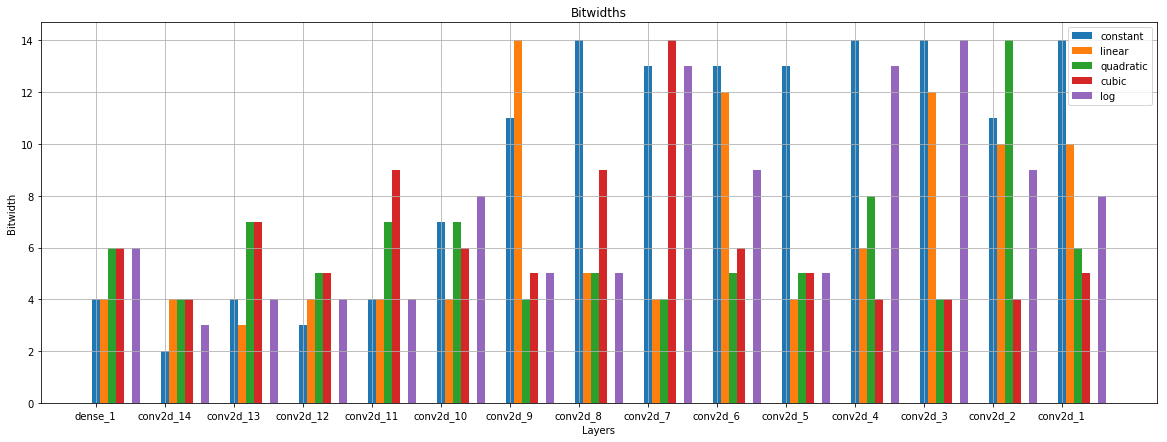

In [45]:
plt.figure(figsize=(20, 7))
width = 0.35
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(opt_params_act.keys()):
    if isinstance(opt_params_act[k], int):
        continue
    bw = [opt_params_act[k][layer][0] for layer in opt_params_act[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x, layer_names, rotation='horizontal')
plt.title('Bitwidths')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();